### 데이터 전처리

1. remove_null_columns(df), remove_single_value_columns(df) 함수 사용
2. failure disk 데이터들에 대해서, linear interpolate
3. 각 failure disk 별로 고장난 날짜 포함 10일에 대해서,timeseries clustering 하려고 함.
4. 처음 관측된 날짜와 fail이 일어난 날짜와의 차이가 9(10-1)보다 작으면, failure disk에서 제외시킴.
5. fail이 일어나기 이전 9일전 + fail이 일어난 날(총 10일) 데이터를 생성(=to_cluster_data)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.metrics import silhouette_score
import mglearn

In [4]:
data = pd.read_csv('../../ssd_data/combined_by_diskmodel/combined_MB1.csv',index_col=False)

# 데이터를 시간 순서대로 정렬 ('ds' 컬럼을 기준으로)
data = data.sort_values(by=['ds'])
data = data.drop_duplicates(subset=['disk_id', 'ds'])
data.reset_index(inplace=True)
del(data['index'])
del(data['level_0'])
data

,disk_id,ds,model,n_1,r_1,n_5,r_5,n_9,r_9,n_12,...,r_244,n_245,r_245,n_175,r_175,n_232,r_232,label,n_211,r_211
0,10005,20190101,MB1,NaN,NaN,100.0,0.0,99.0,4600.0,99.0,...,0.0,100.0,65535.0,NaN,NaN,NaN,NaN,0,NaN,NaN
1,39138,20190101,MB1,NaN,NaN,100.0,0.0,97.0,13256.0,99.0,...,0.0,100.0,65535.0,NaN,NaN,NaN,NaN,0,NaN,NaN
2,3918,20190101,MB1,NaN,NaN,100.0,0.0,97.0,13305.0,99.0,...,0.0,100.0,65535.0,NaN,NaN,NaN,NaN,0,NaN,NaN
3,39187,20190101,MB1,NaN,NaN,100.0,0.0,97.0,12934.0,99.0,...,0.0,100.0,65535.0,NaN,NaN,NaN,NaN,0,NaN,NaN
4,39189,20190101,MB1,NaN,NaN,100.0,0.0,97.0,12934.0,99.0,...,0.0,100.0,65535.0,NaN,NaN,NaN,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7132648,27627,20190630,MB1,NaN,NaN,100.0,0.0,96.0,17027.0,99.0,...,0.0,100.0,65535.0,NaN,NaN,NaN,NaN,0,NaN,NaN
7132649,27631,20190630,MB1,NaN,NaN,100.0,0.0,96.0,17027.0,99.0,...,0.0,100.0,65535.0,NaN,NaN,NaN,NaN,0,NaN,NaN
7132650,27676,20190630,MB1,NaN,NaN,100.0,0.0,96.0,18069.0,99.0,...,0.0,100.0,65535.0,NaN,NaN,NaN,NaN,0,NaN,NaN
7132651,27586,20190630,MB1,NaN,NaN,100.0,0.0,98.0,8476.0,99.0,...,0.0,100.0,65535.0,NaN,NaN,NaN,NaN,0,NaN,NaN


In [5]:
# null값이 있는 열을 제거하는 코드
def remove_null_columns(df):
    # null인 컬럼을 확인하고, 모든 값이 null인 컬럼을 찾습니다.
    null_columns = df.columns[df.isnull().all()]
    
    # 모든 값이 null인 컬럼을 DataFrame에서 제거합니다.
    df = df.drop(null_columns, axis=1)
    
    return df
# 하나의 unique한 값으로만 이루어진 컬럼을 제거하는 코드
def remove_single_value_columns(df):
    single_value_cols = []
    for col in df.columns:
        unique_values = df[col].nunique()
        if unique_values == 1:
            single_value_cols.append(col)

    df_filtered = df.drop(single_value_cols, axis=1)
    return df_filtered


In [6]:
data = remove_null_columns(data)
data = remove_single_value_columns(data)

failed된 disk_id중에서 첫 관측에서 마지막 관측의 결측치 채우기<br>
interpolate-linear

In [7]:
selected_disk_ids = data[data['label']==1]['disk_id'].unique()

dfs_to_concat = []  # 추가할 데이터프레임들을 저장할 리스트

for disk_id in selected_disk_ids:
    disk_data = data[data['disk_id'] == disk_id].copy()
    disk_data['ds'] = pd.to_datetime(disk_data['ds'], format='%Y%m%d')
    disk_data = disk_data.sort_values(by='ds')
    disk_data = disk_data.set_index('ds', drop=True)
    all_dates = pd.date_range(start=disk_data.index.min(), end=disk_data.index.max(), freq='D')
    disk_data = disk_data.reindex(all_dates)
    disk_data = disk_data.interpolate(method='linear')
    dfs_to_concat.append(disk_data)

interpolated_data = pd.concat(dfs_to_concat)  # 데이터프레임들을 연결하여 새로운 데이터프레임 생성

interpolated_data = interpolated_data.reset_index()  # 인덱스 재설정
interpolated_data

,index,disk_id,n_5,r_5,n_9,r_9,n_12,r_12,n_177,r_177,...,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,label
0,2019-01-01,17909.0,99.0,2.0,97.0,12819.0,99.0,19.0,97.0,155.0,...,32.0,199.0,1.0,100.0,0.0,99.0,4.761304e+11,99.0,3.422788e+11,1.0
1,2019-01-02,17909.0,99.0,2.0,97.0,12843.0,99.0,19.0,97.0,155.0,...,31.0,199.0,1.0,100.0,0.0,99.0,4.774871e+11,99.0,3.432220e+11,0.0
2,2019-01-03,17909.0,99.0,2.0,97.0,12867.0,99.0,19.0,97.0,156.0,...,31.0,199.0,1.0,100.0,0.0,99.0,4.790559e+11,99.0,3.467700e+11,0.0
3,2019-01-04,17909.0,99.0,2.0,97.0,12891.0,99.0,19.0,97.0,156.0,...,32.0,199.0,1.0,100.0,0.0,99.0,4.805626e+11,99.0,3.477830e+11,0.0
4,2019-01-05,17909.0,99.0,2.0,97.0,12915.0,99.0,19.0,97.0,157.0,...,31.0,199.0,1.0,100.0,0.0,99.0,4.819720e+11,99.0,3.512526e+11,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43895,2019-06-26,8599.0,100.0,0.0,96.0,17168.0,99.0,21.0,91.0,623.0,...,30.0,200.0,0.0,100.0,0.0,99.0,2.201000e+12,99.0,8.356453e+11,0.0
43896,2019-06-27,8599.0,100.0,0.0,96.0,17192.0,99.0,21.0,91.0,623.0,...,30.0,200.0,0.0,100.0,0.0,99.0,2.201312e+12,99.0,8.362658e+11,0.0
43897,2019-06-28,8599.0,100.0,0.0,96.0,17216.0,99.0,21.0,91.0,624.0,...,31.0,200.0,0.0,100.0,0.0,99.0,2.201585e+12,99.0,8.371074e+11,0.0
43898,2019-06-29,8599.0,99.0,2.0,96.0,17240.0,99.0,21.0,91.0,624.0,...,30.0,200.0,0.0,100.0,0.0,99.0,2.201871e+12,99.0,8.379656e+11,0.0


In [8]:
selected_disk_model_1 = interpolated_data['disk_id'].unique()

to_delete_id =[]
for disk_id in selected_disk_model_1:
    disk_data = interpolated_data[interpolated_data['disk_id'] == disk_id].copy()
    disk_data = disk_data.sort_values(by='index')
    disk_data.reset_index(inplace=True,drop=True)

    failed_index = disk_data[disk_data['label']==1]['index'].index.min()
    start_index = disk_data.index.min()

    if(failed_index - start_index) < 9:
        to_delete_id.append(disk_id)

# failed_disk_index에 해당하는 행들을 제거
data = interpolated_data[~interpolated_data['disk_id'].isin(to_delete_id)]
data

,index,disk_id,n_5,r_5,n_9,r_9,n_12,r_12,n_177,r_177,...,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,label
1109,2019-01-01,43191.0,100.0,0.0,97.0,13760.0,99.0,22.0,97.0,180.0,...,30.0,200.0,0.0,99.0,8.0,99.0,5.307367e+11,99.0,5.859705e+11,0.0
1110,2019-01-02,43191.0,100.0,0.0,97.0,13784.0,99.0,22.0,97.0,181.0,...,30.0,200.0,0.0,99.0,8.0,99.0,5.318034e+11,99.0,5.889655e+11,0.0
1111,2019-01-03,43191.0,100.0,0.0,97.0,13808.0,99.0,22.0,97.0,181.0,...,30.0,200.0,0.0,99.0,8.0,99.0,5.327934e+11,99.0,5.918898e+11,0.0
1112,2019-01-04,43191.0,100.0,0.0,97.0,13832.0,99.0,22.0,97.0,182.0,...,29.0,200.0,0.0,99.0,8.0,99.0,5.338197e+11,99.0,5.947108e+11,0.0
1113,2019-01-05,43191.0,100.0,0.0,97.0,13856.0,99.0,22.0,97.0,183.0,...,32.0,200.0,0.0,99.0,8.0,99.0,5.349756e+11,99.0,5.975866e+11,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43895,2019-06-26,8599.0,100.0,0.0,96.0,17168.0,99.0,21.0,91.0,623.0,...,30.0,200.0,0.0,100.0,0.0,99.0,2.201000e+12,99.0,8.356453e+11,0.0
43896,2019-06-27,8599.0,100.0,0.0,96.0,17192.0,99.0,21.0,91.0,623.0,...,30.0,200.0,0.0,100.0,0.0,99.0,2.201312e+12,99.0,8.362658e+11,0.0
43897,2019-06-28,8599.0,100.0,0.0,96.0,17216.0,99.0,21.0,91.0,624.0,...,31.0,200.0,0.0,100.0,0.0,99.0,2.201585e+12,99.0,8.371074e+11,0.0
43898,2019-06-29,8599.0,99.0,2.0,96.0,17240.0,99.0,21.0,91.0,624.0,...,30.0,200.0,0.0,100.0,0.0,99.0,2.201871e+12,99.0,8.379656e+11,0.0


In [9]:
# 라벨이 1인 행을 필터링합니다.
selected_disk_model_1 = data[data['label'] == 1]

# 모델, disk_id, 그리고 날짜 순으로 정렬합니다.
selected_disk_model_1 = selected_disk_model_1.sort_values(by=['disk_id', 'index'])

# disk_id와 model 열만을 선택하여 새로운 데이터 프레임에 저장합니다.
selected_disk_model_1 = selected_disk_model_1[['disk_id']].drop_duplicates().reset_index(drop=True)

# 결과 데이터 프레임을 출력합니다.
selected_disk_model_1.shape

(268, 1)

In [10]:
to_cluster_data = pd.DataFrame()

for disk_id in selected_disk_model_1['disk_id'].unique():
    disk_data = data[data['disk_id'] == disk_id].copy()
    disk_data = disk_data.sort_values(by='index')
    disk_data.reset_index(inplace=True,drop=True)

    failed_index = disk_data[disk_data['label']==1]['index'].index.min()
    before_9day_index = failed_index - 9

    to_cluster = disk_data.iloc[before_9day_index:failed_index+1, :]
    to_cluster_data = pd.concat([to_cluster_data,to_cluster],axis=0)
    
to_cluster_data

,index,disk_id,n_5,r_5,n_9,r_9,n_12,r_12,n_177,r_177,...,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,label
74,2019-03-16,470.0,99.0,4.0,96.0,16054.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.743607e+09,0.0
75,2019-03-17,470.0,99.0,4.0,96.0,16078.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.744597e+09,0.0
76,2019-03-18,470.0,99.0,4.0,96.0,16102.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.745809e+09,0.0
77,2019-03-19,470.0,99.0,4.0,96.0,16126.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.747037e+09,0.0
78,2019-03-20,470.0,99.0,4.0,96.0,16150.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.748307e+09,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,2019-03-21,44338.0,99.0,2.0,96.0,16176.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.778025e+09,0.0
80,2019-03-22,44338.0,99.0,2.0,96.0,16200.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.779657e+09,0.0
81,2019-03-23,44338.0,99.0,2.0,96.0,16224.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.781085e+09,0.0
82,2019-03-24,44338.0,99.0,2.0,96.0,16248.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.782419e+09,0.0


In [11]:
#10일씩 제대로 묶였는지 확인 => ok
to_cluster_data[to_cluster_data['disk_id']==470]

,index,disk_id,n_5,r_5,n_9,r_9,n_12,r_12,n_177,r_177,...,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,label
74,2019-03-16,470.0,99.0,4.0,96.0,16054.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.743607e+09,0.0
75,2019-03-17,470.0,99.0,4.0,96.0,16078.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.744597e+09,0.0
76,2019-03-18,470.0,99.0,4.0,96.0,16102.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.745809e+09,0.0
77,2019-03-19,470.0,99.0,4.0,96.0,16126.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.747037e+09,0.0
78,2019-03-20,470.0,99.0,4.0,96.0,16150.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.748307e+09,0.0
79,2019-03-21,470.0,99.0,4.0,96.0,16174.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.749580e+09,0.0
80,2019-03-22,470.0,99.0,4.0,96.0,16198.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.750794e+09,0.0
81,2019-03-23,470.0,99.0,4.0,96.0,16222.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.751875e+09,0.0
82,2019-03-24,470.0,99.0,4.0,96.0,16246.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.752874e+09,0.0
83,2019-03-25,470.0,99.0,4.0,96.0,16270.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.754062e+09,1.0


### k=4 DTW_kmeans

In [54]:
#Scaling 과정
from sklearn.preprocessing import MinMaxScaler

# feature_data = to_cluster_data.sort_values(by=["disk_id", "index"]).drop(columns=['index','disk_id','label'])

# scaler = MinMaxScaler()
# sclaed_feature_data = scaler.fit_transform(feature_data)

# Assuming 'X_train' is the original DataFrame before scaling and its columns are to be preserved
#scaled_cluster_df = pd.DataFrame(sclaed_feature_data, columns=feature_data.columns, index=feature_data.index)
#to_cluster_df = pd.concat([to_cluster_data.sort_values(by=["disk_id", "index"])[['index','disk_id','label']],scaled_cluster_df], axis=1)

to_cluster = to_cluster_data.drop(columns=['index','label'])

grouped = to_cluster.groupby("disk_id").apply(np.array)

to_cluster = np.array(grouped.tolist())  # This is now a 3D array (n_samples, n_timestamps, n_features)
to_cluster = to_cluster[:, :, 1:]
to_cluster.shape

(268, 10, 32)

실루엣 스코어랑 inertia를 보자

In [35]:
# Scale the data
scaler = TimeSeriesScalerMeanVariance()
data_scaled = scaler.fit_transform(to_cluster)

In [36]:
def calculate_scores(num_clusters, data_scaled):
    km_dtw = TimeSeriesKMeans(n_clusters=num_clusters, metric="dtw")
    clusters = km_dtw.fit_predict(data_scaled)
    silhouette = silhouette_score(data_scaled.reshape(data_scaled.shape[0], -1), clusters)
    inertia = km_dtw.inertia_
    return silhouette, inertia

In [37]:
num_clusters_range = range(2, 11)
silhouette_scores = []
inertia_scores = []

for k in num_clusters_range:
    silhouette, inertia = calculate_scores(k, data_scaled)
    silhouette_scores.append(silhouette)
    inertia_scores.append(inertia)

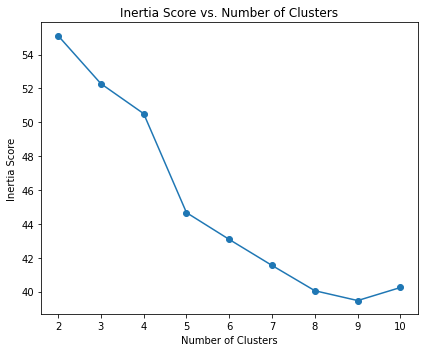

In [43]:
# Plot only the Inertia Score vs. Number of Clusters
plt.figure(figsize=(6, 5))
plt.plot(num_clusters_range, inertia_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia Score")
plt.title("Inertia Score vs. Number of Clusters")
plt.tight_layout()
plt.show()

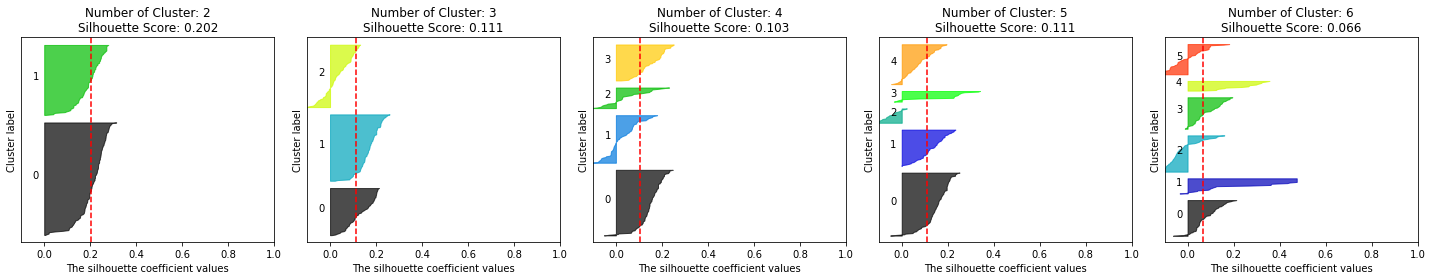

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.metrics import silhouette_score, silhouette_samples

# Assuming you have already scaled your time series data (data_scaled) using TimeSeriesScalerMeanVariance
def visualize_silhouette(cluster_lists, data_scaled):
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4 * n_cols, 4), nrows=1, ncols=n_cols)

    # Flatten the 3-dimensional time series data into 2-dimensional array
    data_reshaped = data_scaled.reshape(data_scaled.shape[0], -1)

    for ind, n_cluster in enumerate(cluster_lists):
        km_dtw = TimeSeriesKMeans(n_clusters=n_cluster, metric="dtw", verbose=False)
        clusters = km_dtw.fit_predict(data_scaled)

        # Calculate the silhouette score on the reshaped data
        silhouette_avg = silhouette_score(data_reshaped, clusters)

        sample_silhouette_values = silhouette_samples(data_reshaped, clusters)
        y_lower = 10

        axs[ind].set_title('Number of Cluster: ' + str(n_cluster) + '\n'
                          'Silhouette Score: ' + str(round(silhouette_avg, 3)))
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(data_scaled) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        for i in range(n_cluster):
            ith_cluster_sil_values = sample_silhouette_values[clusters == i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = plt.cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values,
                                   facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=silhouette_avg, color="red", linestyle="--")

# Example usage with your data_scaled (assuming it's a NumPy array of time series data)
visualize_silhouette(range(2, 7), data_scaled)
plt.tight_layout()
plt.show()

원하는 군집수를 정해서 분류 시작

In [44]:
# Choose the number of clusters (k) you want
k = 5

# Run the TimeSeriesKMeans algorithm with DTW distance
km_dtw = TimeSeriesKMeans(n_clusters=k, metric="dtw")
clusters = km_dtw.fit_predict(data_scaled)

In [45]:
clusters

array([0, 0, 2, 1, 1, 1, 2, 2, 0, 1, 1, 2, 2, 2, 2, 2, 3, 0, 0, 2, 3, 3,
       4, 2, 1, 4, 3, 3, 3, 1, 3, 1, 1, 1, 2, 1, 1, 2, 1, 0, 0, 3, 1, 2,
       3, 2, 2, 1, 2, 1, 0, 1, 1, 1, 3, 4, 2, 3, 3, 2, 1, 3, 1, 4, 4, 1,
       1, 2, 2, 2, 2, 0, 1, 2, 1, 2, 2, 1, 1, 1, 1, 0, 2, 2, 1, 3, 1, 2,
       1, 2, 2, 1, 3, 0, 4, 1, 1, 1, 4, 3, 3, 1, 3, 1, 4, 4, 1, 1, 1, 1,
       1, 1, 1, 1, 4, 2, 1, 2, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 3, 0, 3, 4,
       1, 4, 3, 3, 1, 3, 3, 2, 2, 0, 2, 2, 1, 2, 0, 1, 1, 3, 3, 3, 1, 2,
       2, 1, 2, 1, 2, 2, 1, 1, 3, 0, 2, 0, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 2, 2, 4, 2, 1, 2, 4, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 3, 1, 3,
       3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 2, 2, 3, 1, 4, 4, 3, 1, 0, 4,
       1, 1, 1, 1, 3, 3, 3, 1, 4, 3, 3, 2, 3, 1, 0, 3, 1, 2, 2, 1, 1, 2,
       3, 4, 3, 2, 1, 2, 1, 2, 0, 3, 2, 0, 0, 2, 3, 4, 3, 0, 2, 3, 2, 1,
       3, 1, 0, 3], dtype=int64)

In [46]:
to_cluster_df.reset_index(inplace=True,drop=True)

to_cluster_df['cluster']=0
for i, cluster in enumerate(clusters):
    to_cluster_df.loc[i*10:i*10+10, 'cluster'] = cluster
to_cluster_df

,index,disk_id,label,n_5,r_5,n_9,r_9,n_12,r_12,n_177,...,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,cluster
0,2019-03-16,470.0,0.0,0.979592,0.001253,0.0,0.803376,0.0,0.122951,0.909091,...,0.388889,1.0,0.0,1.0,0.0,1.0,0.004817,1.0,0.002485,0
1,2019-03-17,470.0,0.0,0.979592,0.001253,0.0,0.804578,0.0,0.122951,0.909091,...,0.388889,1.0,0.0,1.0,0.0,1.0,0.004817,1.0,0.002486,0
2,2019-03-18,470.0,0.0,0.979592,0.001253,0.0,0.805780,0.0,0.122951,0.909091,...,0.388889,1.0,0.0,1.0,0.0,1.0,0.004817,1.0,0.002486,0
3,2019-03-19,470.0,0.0,0.979592,0.001253,0.0,0.806982,0.0,0.122951,0.909091,...,0.388889,1.0,0.0,1.0,0.0,1.0,0.004817,1.0,0.002486,0
4,2019-03-20,470.0,0.0,0.979592,0.001253,0.0,0.808184,0.0,0.122951,0.909091,...,0.388889,1.0,0.0,1.0,0.0,1.0,0.004817,1.0,0.002487,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2675,2019-03-21,44338.0,0.0,0.979592,0.000627,0.0,0.809486,0.0,0.147541,0.909091,...,0.500000,1.0,0.0,1.0,0.0,1.0,0.004709,1.0,0.002495,3
2676,2019-03-22,44338.0,0.0,0.979592,0.000627,0.0,0.810688,0.0,0.147541,0.909091,...,0.500000,1.0,0.0,1.0,0.0,1.0,0.004709,1.0,0.002496,3
2677,2019-03-23,44338.0,0.0,0.979592,0.000627,0.0,0.811890,0.0,0.147541,0.909091,...,0.500000,1.0,0.0,1.0,0.0,1.0,0.004709,1.0,0.002496,3
2678,2019-03-24,44338.0,0.0,0.979592,0.000627,0.0,0.813092,0.0,0.147541,0.909091,...,0.500000,1.0,0.0,1.0,0.0,1.0,0.004709,1.0,0.002496,3


In [47]:
df = to_cluster_df.drop(columns=['index','label'])

cluster_0 = df[df['cluster']==0].drop('cluster',axis=1).copy()
cluster_1 = df[df['cluster']==1].drop('cluster',axis=1).copy()
cluster_2 = df[df['cluster']==2].drop('cluster',axis=1).copy()
cluster_3 = df[df['cluster']==3].drop('cluster',axis=1).copy()
cluster_4 = df[df['cluster']==4].drop('cluster',axis=1).copy()

cluster_0_grouped = cluster_0.groupby(['disk_id']).apply(np.array)
cluster_1_grouped = cluster_1.groupby(['disk_id']).apply(np.array)
cluster_2_grouped = cluster_2.groupby(['disk_id']).apply(np.array)
cluster_3_grouped = cluster_3.groupby(['disk_id']).apply(np.array)
cluster_4_grouped = cluster_4.groupby(['disk_id']).apply(np.array)

cluster_0_arr = np.array(cluster_0_grouped.tolist())  # This is now a 3D groupby (n_samples, n_timestamps, n_features)
cluster_1_arr = np.array(cluster_1_grouped.tolist())
cluster_2_arr = np.array(cluster_2_grouped.tolist())
cluster_3_arr = np.array(cluster_3_grouped.tolist())
cluster_4_arr = np.array(cluster_4_grouped.tolist())

print('cluster_0_arr 의 shpae:',cluster_0_arr.shape)
print('cluster_1_arr 의 shpae:',cluster_1_arr.shape)
print('cluster_2_arr 의 shpae:',cluster_2_arr.shape)
print('cluster_3_arr 의 shpae:',cluster_3_arr.shape)
print('cluster_4_arr 의 shpae:',cluster_4_arr.shape)

cluster_0_arr 의 shpae: (23, 10, 33)
cluster_1_arr 의 shpae: (91, 10, 33)
cluster_2_arr 의 shpae: (71, 10, 33)
cluster_3_arr 의 shpae: (63, 10, 33)
cluster_4_arr 의 shpae: (20, 10, 33)


In [48]:
import numpy as np

# Calculate the mean along the first axis
cluster_0_mean_data = np.mean(cluster_0_arr, axis=0)
cluster_1_mean_data = np.mean(cluster_1_arr, axis=0)
cluster_2_mean_data = np.mean(cluster_2_arr, axis=0)
cluster_3_mean_data = np.mean(cluster_3_arr, axis=0)
cluster_4_mean_data = np.mean(cluster_4_arr, axis=0)

# Now 'mean_data' has shape (10, 33)
print(cluster_0_mean_data.shape)  # Output: (10, 33)

(10, 33)


In [49]:
cluster_0_mean_df = pd.DataFrame(cluster_0_mean_data, columns=cluster_0.columns)
del(cluster_0_mean_df['disk_id'])

cluster_1_mean_df = pd.DataFrame(cluster_1_mean_data, columns=cluster_1.columns)
del(cluster_1_mean_df['disk_id'])

cluster_2_mean_df = pd.DataFrame(cluster_2_mean_data, columns=cluster_2.columns)
del(cluster_2_mean_df['disk_id'])

cluster_3_mean_df = pd.DataFrame(cluster_3_mean_data, columns=cluster_3.columns)
del(cluster_3_mean_df['disk_id'])

cluster_4_mean_df = pd.DataFrame(cluster_4_mean_data, columns=cluster_4.columns)
del(cluster_4_mean_df['disk_id'])

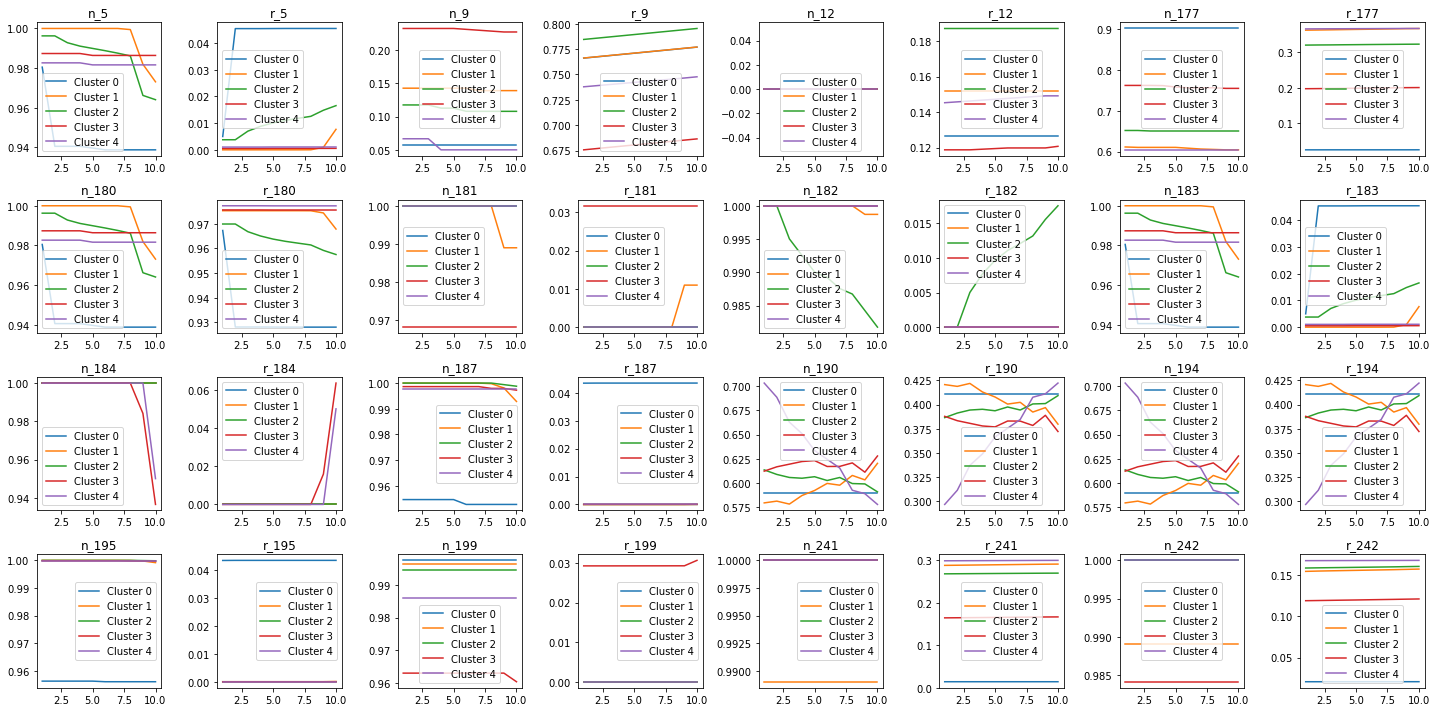

In [50]:
import matplotlib.pyplot as plt

# Assuming the dataframes are named 'cluster_0_mean_df', 'cluster_1_mean_df', 'cluster_2_mean_df', 'cluster_3_mean_df'
clusters = [cluster_0_mean_df, cluster_1_mean_df, cluster_2_mean_df, cluster_3_mean_df,cluster_4_mean_df]
cluster_names = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3','Cluster 4']

# feature names list
feature_names = cluster_0_mean_df.columns.tolist()

# Create subplots with 4 rows and 8 columns, each cell will represent a feature
fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(20, 10))

# Reshape the axes array to 1D for easy iteration
axs = axs.ravel()

for i in range(len(feature_names)):
    for j in range(5):
        # Plot each cluster's line in the same subplot (feature)
        axs[i].plot(clusters[j].index + 1, clusters[j].iloc[:, i], label=cluster_names[j])
        
    axs[i].set_title(feature_names[i])
    axs[i].legend()

plt.tight_layout()
plt.show()

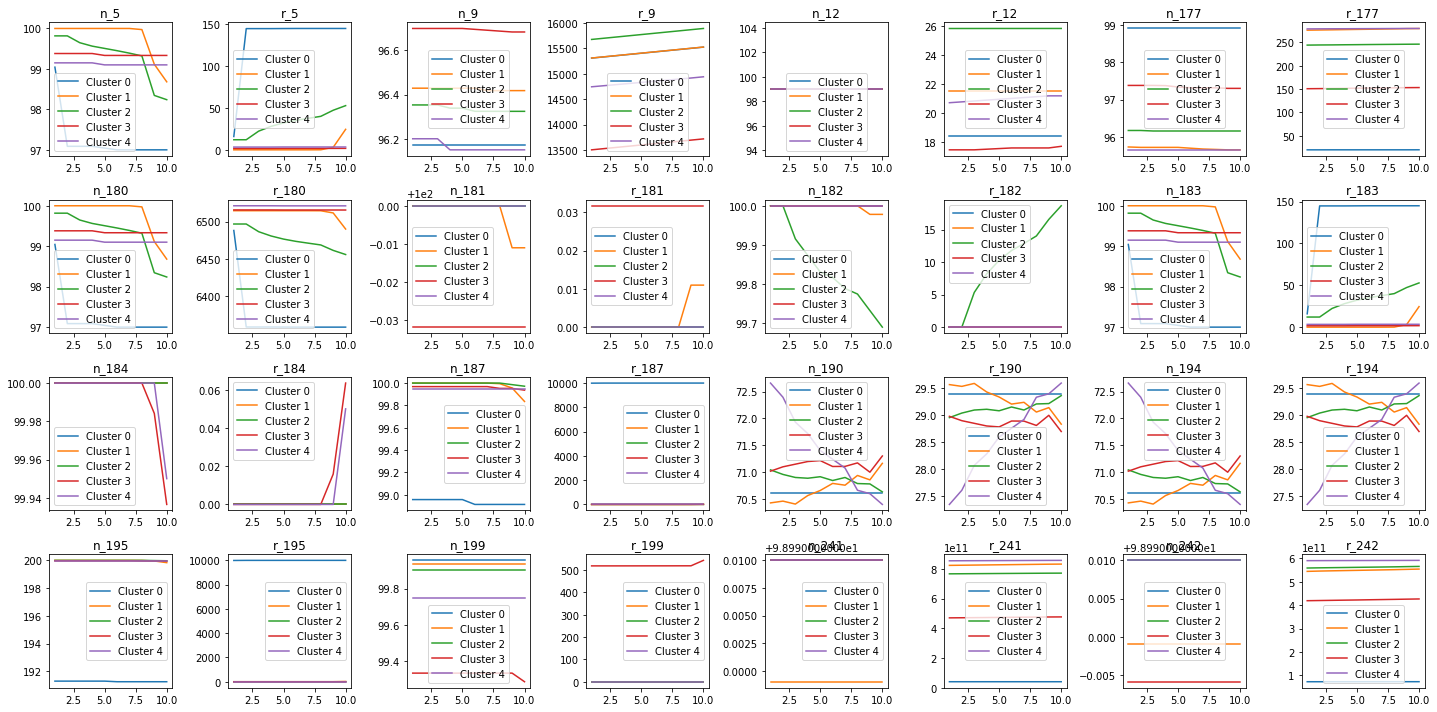

In [51]:
# Assuming the dataframes are named 'cluster_0_mean_df', 'cluster_1_mean_df', 'cluster_2_mean_df', 'cluster_3_mean_df'
clusters = [cluster_0_mean_df, cluster_1_mean_df, cluster_2_mean_df, cluster_3_mean_df, cluster_4_mean_df]
cluster_names = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']

# feature names list
feature_names = cluster_0_mean_df.columns.tolist()

# Inverse Min-Max Scaling function
def inverse_min_max_scaling(x, x_min, x_max):
    return x * (x_max - x_min) + x_min

# Create subplots with 4 rows and 8 columns, each cell will represent a feature
fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(20, 10))

# Reshape the axes array to 1D for easy iteration
axs = axs.ravel()

for i in range(len(feature_names)):
    for j in range(5):
        # Apply inverse Min-Max Scaling to cluster data before plotting
        original_values = inverse_min_max_scaling(clusters[j].iloc[:, i], feature_data[feature_names[i]].min(), feature_data[feature_names[i]].max())
        axs[i].plot(clusters[j].index + 1, original_values, label=cluster_names[j])
        
    axs[i].set_title(feature_names[i])
    axs[i].legend()

plt.tight_layout()
plt.show()

In [163]:
#/ssd_data/clustering_data 폴더 만들고 실행하기!!
to_cluster_df.to_csv('../ssd_data/clustering_data/DTW_Kmeans_4.csv',index=False)

#### tsne로 각 cluster가 잘 구분되어있는지 시각화

In [165]:
to_cluster_df

,index,disk_id,label,n_5,r_5,n_9,r_9,n_12,r_12,n_177,...,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,cluster
0,2019-03-16,470.0,0.0,0.979592,0.001253,0.0,0.803376,0.0,0.122951,0.909091,...,0.388889,1.0,0.0,1.0,0.0,1.0,0.004817,1.0,0.002485,0
1,2019-03-17,470.0,0.0,0.979592,0.001253,0.0,0.804578,0.0,0.122951,0.909091,...,0.388889,1.0,0.0,1.0,0.0,1.0,0.004817,1.0,0.002486,0
2,2019-03-18,470.0,0.0,0.979592,0.001253,0.0,0.805780,0.0,0.122951,0.909091,...,0.388889,1.0,0.0,1.0,0.0,1.0,0.004817,1.0,0.002486,0
3,2019-03-19,470.0,0.0,0.979592,0.001253,0.0,0.806982,0.0,0.122951,0.909091,...,0.388889,1.0,0.0,1.0,0.0,1.0,0.004817,1.0,0.002486,0
4,2019-03-20,470.0,0.0,0.979592,0.001253,0.0,0.808184,0.0,0.122951,0.909091,...,0.388889,1.0,0.0,1.0,0.0,1.0,0.004817,1.0,0.002487,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2675,2019-03-21,44338.0,0.0,0.979592,0.000627,0.0,0.809486,0.0,0.147541,0.909091,...,0.500000,1.0,0.0,1.0,0.0,1.0,0.004709,1.0,0.002495,0
2676,2019-03-22,44338.0,0.0,0.979592,0.000627,0.0,0.810688,0.0,0.147541,0.909091,...,0.500000,1.0,0.0,1.0,0.0,1.0,0.004709,1.0,0.002496,0
2677,2019-03-23,44338.0,0.0,0.979592,0.000627,0.0,0.811890,0.0,0.147541,0.909091,...,0.500000,1.0,0.0,1.0,0.0,1.0,0.004709,1.0,0.002496,0
2678,2019-03-24,44338.0,0.0,0.979592,0.000627,0.0,0.813092,0.0,0.147541,0.909091,...,0.500000,1.0,0.0,1.0,0.0,1.0,0.004709,1.0,0.002496,0


In [171]:
from sklearn.manifold import TSNE

x_data = to_cluster_df.drop(columns=['index','disk_id','label','cluster'])
# dim reduction with tsne
tsne = TSNE(random_state=42)
# use fit_transform instead of fit, as TSNE has no transform method. not be used as preprocessing step of supervised learning
tsne_data = tsne.fit_transform(x_data)

Text(0, 0.5, 'Second principal component')

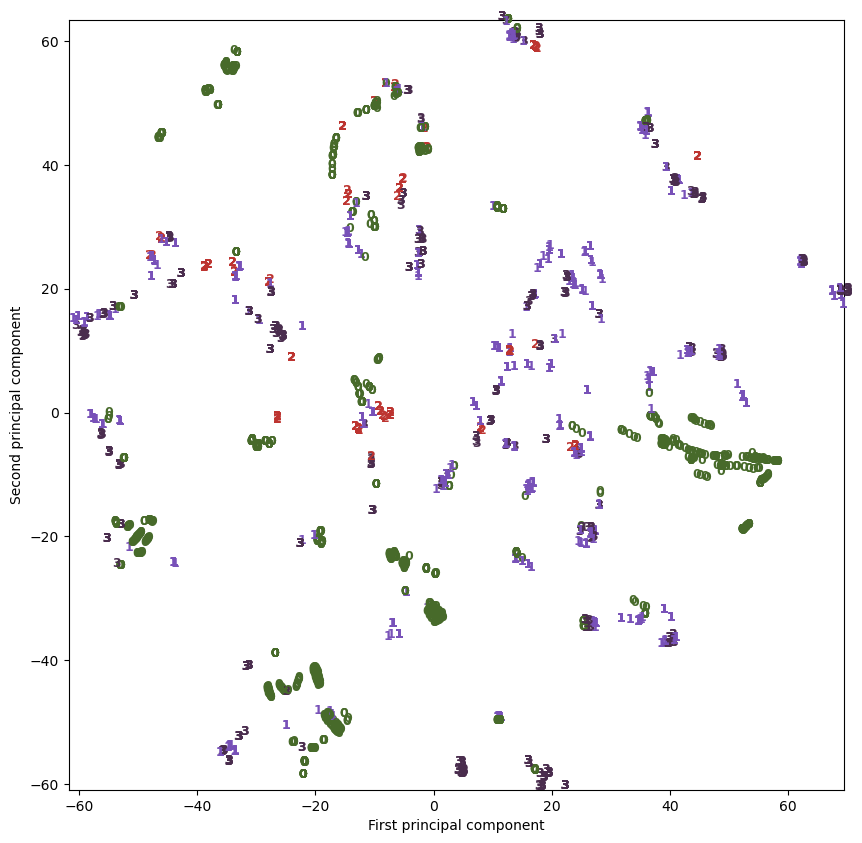

In [172]:
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
plt.figure(figsize=(10, 10))
plt.xlim(tsne_data[:, 0].min(), tsne_data[:, 0].max())
plt.ylim(tsne_data[:, 1].min(), tsne_data[:, 1].max())
for i in range(len(to_cluster_df)):
    # actually plot the digits as text instead of using scatter
    plt.text(tsne_data[i, 0], tsne_data[i, 1], str(list(to_cluster_df['cluster'])[i]),
             color = colors[list(to_cluster_df['cluster'])[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
#상대적으로 잘 뭉쳐져있다! -> 시각화하는데 잘 사용됨.

- 잘 나눠졌는지 모르겠어서, 3차원으로 확인

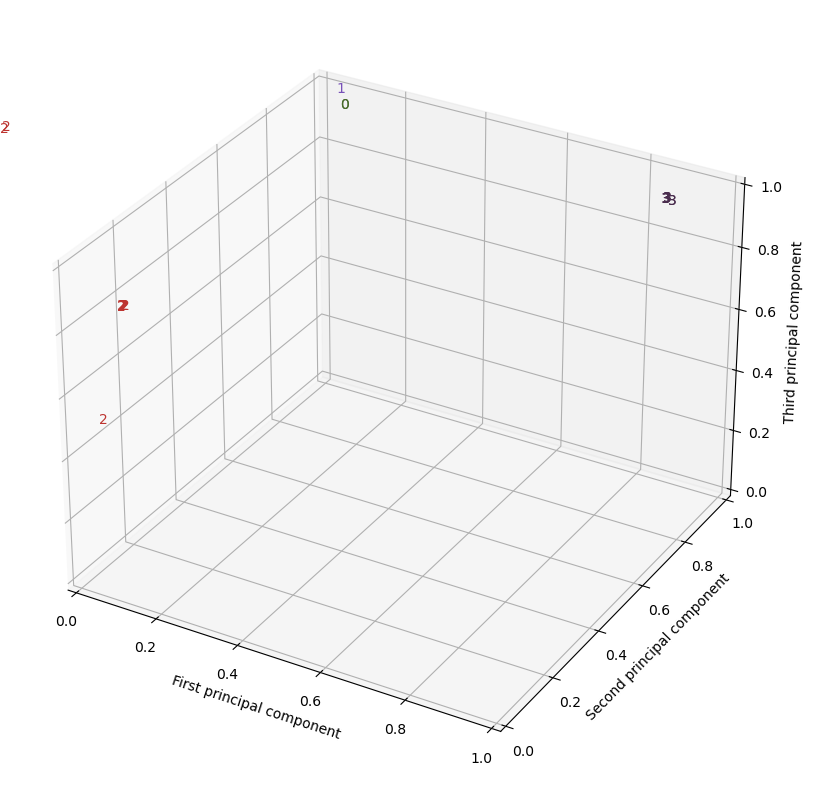

In [173]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x_data = to_cluster_df.drop(columns=['index','disk_id','label','cluster'])

# Reduce dimensions with t-SNE
tsne = TSNE(n_components=3, random_state=42) # set n_components to 3 for 3D
tsne_data = tsne.fit_transform(x_data)

colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]

# Create a 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(to_cluster_df)):
    ax.text(tsne_data[i, 0], tsne_data[i, 1], tsne_data[i, 2], str(list(to_cluster_df['cluster'])[i]),
             color = colors[list(to_cluster_df['cluster'])[i]])

ax.set_xlabel("First principal component")
ax.set_ylabel("Second principal component")
ax.set_zlabel("Third principal component")
plt.show()

- 0,1 클러스터는 거의 뭉쳐있음
- 0,1을 하나의 클러스터로 본다면, 총 3개의 클러스터로 묶을수 있을거같다.
- k=4 에서 k=3으로 설정하고 클러스터링 시도해보면 좋을거같음.

### k=3 DTW_kmeans

In [175]:
#Scaling 과정
from sklearn.preprocessing import MinMaxScaler

feature_data = to_cluster_data.sort_values(by=["disk_id", "index"]).drop(columns=['index','disk_id','label'])

scaler = MinMaxScaler()
sclaed_feature_data = scaler.fit_transform(feature_data)

# Assuming 'X_train' is the original DataFrame before scaling and its columns are to be preserved
scaled_cluster_df = pd.DataFrame(sclaed_feature_data, columns=feature_data.columns, index=feature_data.index)
to_cluster_df = pd.concat([to_cluster_data.sort_values(by=["disk_id", "index"])[['index','disk_id','label']],scaled_cluster_df], axis=1)

to_cluster = to_cluster_df.drop(columns=['index','label'])

grouped = to_cluster.groupby("disk_id").apply(np.array)

to_cluster = np.array(grouped.tolist())  # This is now a 3D array (n_samples, n_timestamps, n_features)
to_cluster = to_cluster[:, :, 1:]
to_cluster.shape

(268, 10, 32)

In [176]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# Scale the data
scaler = TimeSeriesScalerMeanVariance()
data_scaled = scaler.fit_transform(to_cluster)

# Choose the number of clusters (k) you want
k = 3

# Run the TimeSeriesKMeans algorithm with DTW distance
km_dtw = TimeSeriesKMeans(n_clusters=k, metric="dtw")
clusters = km_dtw.fit_predict(data_scaled)

In [177]:
clusters

array([0, 0, 2, 1, 1, 1, 2, 2, 0, 1, 1, 2, 1, 2, 2, 2, 1, 0, 0, 2, 0, 0,
       0, 2, 1, 0, 0, 0, 0, 2, 0, 1, 1, 1, 1, 1, 1, 2, 1, 0, 0, 0, 1, 1,
       0, 2, 2, 1, 2, 2, 0, 2, 1, 1, 0, 0, 2, 0, 0, 1, 1, 0, 2, 0, 0, 1,
       1, 1, 2, 2, 2, 0, 2, 2, 1, 2, 2, 1, 1, 2, 2, 0, 2, 2, 1, 0, 1, 2,
       2, 2, 1, 1, 0, 0, 0, 1, 2, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 2, 0, 2, 1, 2, 0, 1, 0, 0, 1, 0, 1, 2, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 1, 1, 2, 0, 1, 1, 0, 0, 0, 1, 1,
       2, 1, 1, 1, 2, 2, 1, 2, 0, 0, 2, 0, 0, 2, 2, 1, 2, 1, 1, 1, 2, 1,
       1, 2, 2, 0, 2, 1, 1, 0, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 0, 2, 0,
       0, 0, 2, 1, 0, 0, 0, 0, 0, 1, 0, 0, 2, 2, 0, 1, 0, 0, 0, 1, 2, 0,
       1, 1, 1, 2, 0, 0, 0, 1, 0, 0, 0, 2, 0, 1, 0, 0, 2, 2, 2, 1, 2, 2,
       0, 0, 0, 2, 1, 2, 1, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2,
       1, 1, 0, 0], dtype=int64)

In [178]:
to_cluster_df.reset_index(inplace=True,drop=True)

to_cluster_df['cluster']=0
for i, cluster in enumerate(clusters):
    to_cluster_df.loc[i*10:i*10+10, 'cluster'] = cluster
to_cluster_df

,index,disk_id,label,n_5,r_5,n_9,r_9,n_12,r_12,n_177,...,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,cluster
0,2019-03-16,470.0,0.0,0.979592,0.001253,0.0,0.803376,0.0,0.122951,0.909091,...,0.388889,1.0,0.0,1.0,0.0,1.0,0.004817,1.0,0.002485,0
1,2019-03-17,470.0,0.0,0.979592,0.001253,0.0,0.804578,0.0,0.122951,0.909091,...,0.388889,1.0,0.0,1.0,0.0,1.0,0.004817,1.0,0.002486,0
2,2019-03-18,470.0,0.0,0.979592,0.001253,0.0,0.805780,0.0,0.122951,0.909091,...,0.388889,1.0,0.0,1.0,0.0,1.0,0.004817,1.0,0.002486,0
3,2019-03-19,470.0,0.0,0.979592,0.001253,0.0,0.806982,0.0,0.122951,0.909091,...,0.388889,1.0,0.0,1.0,0.0,1.0,0.004817,1.0,0.002486,0
4,2019-03-20,470.0,0.0,0.979592,0.001253,0.0,0.808184,0.0,0.122951,0.909091,...,0.388889,1.0,0.0,1.0,0.0,1.0,0.004817,1.0,0.002487,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2675,2019-03-21,44338.0,0.0,0.979592,0.000627,0.0,0.809486,0.0,0.147541,0.909091,...,0.500000,1.0,0.0,1.0,0.0,1.0,0.004709,1.0,0.002495,0
2676,2019-03-22,44338.0,0.0,0.979592,0.000627,0.0,0.810688,0.0,0.147541,0.909091,...,0.500000,1.0,0.0,1.0,0.0,1.0,0.004709,1.0,0.002496,0
2677,2019-03-23,44338.0,0.0,0.979592,0.000627,0.0,0.811890,0.0,0.147541,0.909091,...,0.500000,1.0,0.0,1.0,0.0,1.0,0.004709,1.0,0.002496,0
2678,2019-03-24,44338.0,0.0,0.979592,0.000627,0.0,0.813092,0.0,0.147541,0.909091,...,0.500000,1.0,0.0,1.0,0.0,1.0,0.004709,1.0,0.002496,0


In [179]:
df = to_cluster_df.drop(columns=['index','label'])

cluster_0 = df[df['cluster']==0].drop('cluster',axis=1).copy()
cluster_1 = df[df['cluster']==1].drop('cluster',axis=1).copy()
cluster_2 = df[df['cluster']==2].drop('cluster',axis=1).copy()

cluster_0_grouped = cluster_0.groupby(['disk_id']).apply(np.array)
cluster_1_grouped = cluster_1.groupby(['disk_id']).apply(np.array)
cluster_2_grouped = cluster_2.groupby(['disk_id']).apply(np.array)

cluster_0_arr = np.array(cluster_0_grouped.tolist())  # This is now a 3D groupby (n_samples, n_timestamps, n_features)
cluster_1_arr = np.array(cluster_1_grouped.tolist())
cluster_2_arr = np.array(cluster_2_grouped.tolist())

print('cluster_0_arr 의 shpae:',cluster_0_arr.shape)
print('cluster_1_arr 의 shpae:',cluster_1_arr.shape)
print('cluster_2_arr 의 shpae:',cluster_2_arr.shape)

cluster_0_arr 의 shpae: (102, 10, 33)
cluster_1_arr 의 shpae: (85, 10, 33)
cluster_2_arr 의 shpae: (81, 10, 33)


In [180]:
import numpy as np

# Calculate the mean along the first axis
cluster_0_mean_data = np.mean(cluster_0_arr, axis=0)
cluster_1_mean_data = np.mean(cluster_1_arr, axis=0)
cluster_2_mean_data = np.mean(cluster_2_arr, axis=0)
cluster_3_mean_data = np.mean(cluster_3_arr, axis=0)

# Now 'mean_data' has shape (10, 33)
print(cluster_0_mean_data.shape)  # Output: (10, 33)

(10, 33)


In [181]:
cluster_0_mean_df = pd.DataFrame(cluster_0_mean_data, columns=cluster_0.columns)
del(cluster_0_mean_df['disk_id'])

cluster_1_mean_df = pd.DataFrame(cluster_1_mean_data, columns=cluster_1.columns)
del(cluster_1_mean_df['disk_id'])

cluster_2_mean_df = pd.DataFrame(cluster_2_mean_data, columns=cluster_2.columns)
del(cluster_2_mean_df['disk_id'])

cluster_3_mean_df = pd.DataFrame(cluster_3_mean_data, columns=cluster_3.columns)
del(cluster_3_mean_df['disk_id'])

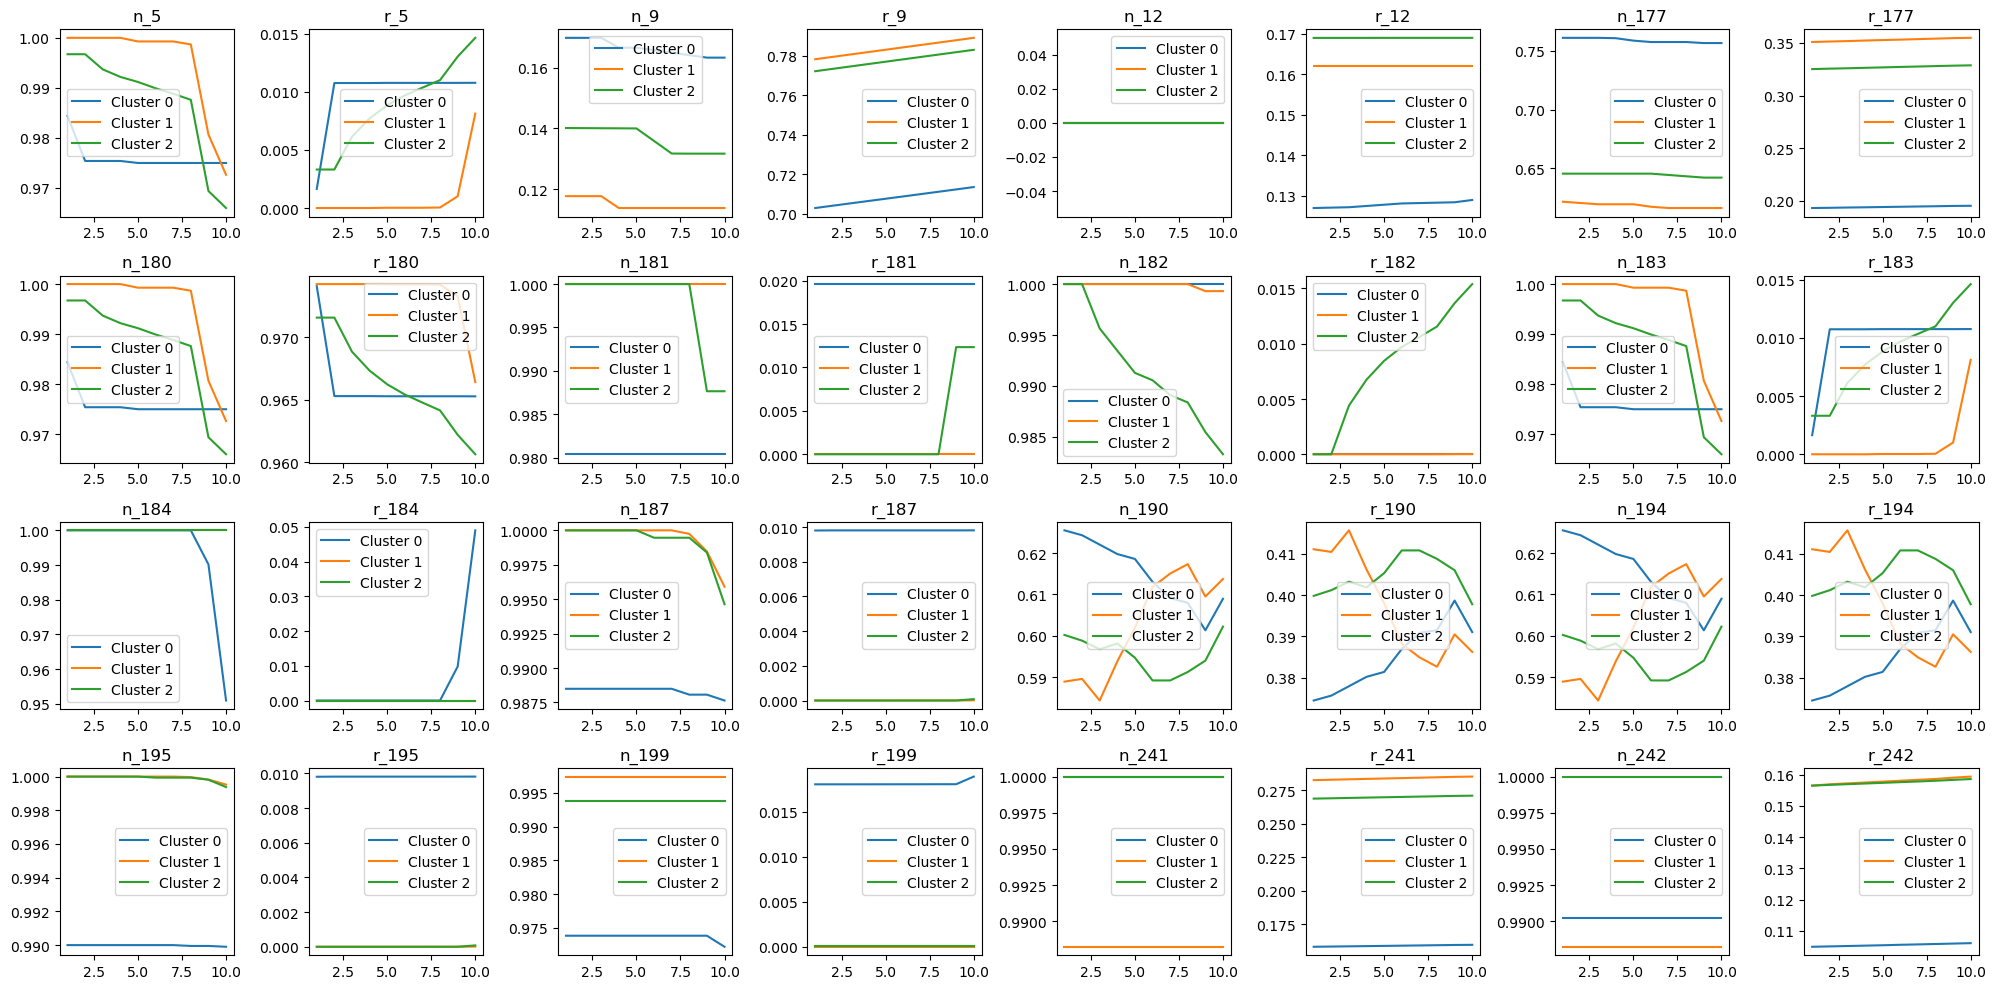

In [189]:
import matplotlib.pyplot as plt

# Assuming the dataframes are named 'cluster_0_mean_df', 'cluster_1_mean_df', 'cluster_2_mean_df', 'cluster_3_mean_df'
clusters = [cluster_0_mean_df, cluster_1_mean_df, cluster_2_mean_df]
cluster_names = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']

# feature names list
feature_names = cluster_0_mean_df.columns.tolist()

# Create subplots with 4 rows and 8 columns, each cell will represent a feature
fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(20, 10))

# Reshape the axes array to 1D for easy iteration
axs = axs.ravel()

for i in range(len(feature_names)):
    for j in range(3):
        # Plot each cluster's line in the same subplot (feature)
        axs[i].plot(clusters[j].index + 1, clusters[j].iloc[:, i], label=cluster_names[j])
        
    axs[i].set_title(feature_names[i])
    axs[i].legend()

plt.tight_layout()
plt.show()

In [183]:
#/ssd_data/clustering_data 폴더 만들고 실행하기!!
to_cluster_df.to_csv('../ssd_data/clustering_data/DTW_Kmeans_3.csv',index=False)

#### tsne로 각 cluster가 잘 구분되어있는지 시각화

In [184]:
to_cluster_df

,index,disk_id,label,n_5,r_5,n_9,r_9,n_12,r_12,n_177,...,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,cluster
0,2019-03-16,470.0,0.0,0.979592,0.001253,0.0,0.803376,0.0,0.122951,0.909091,...,0.388889,1.0,0.0,1.0,0.0,1.0,0.004817,1.0,0.002485,0
1,2019-03-17,470.0,0.0,0.979592,0.001253,0.0,0.804578,0.0,0.122951,0.909091,...,0.388889,1.0,0.0,1.0,0.0,1.0,0.004817,1.0,0.002486,0
2,2019-03-18,470.0,0.0,0.979592,0.001253,0.0,0.805780,0.0,0.122951,0.909091,...,0.388889,1.0,0.0,1.0,0.0,1.0,0.004817,1.0,0.002486,0
3,2019-03-19,470.0,0.0,0.979592,0.001253,0.0,0.806982,0.0,0.122951,0.909091,...,0.388889,1.0,0.0,1.0,0.0,1.0,0.004817,1.0,0.002486,0
4,2019-03-20,470.0,0.0,0.979592,0.001253,0.0,0.808184,0.0,0.122951,0.909091,...,0.388889,1.0,0.0,1.0,0.0,1.0,0.004817,1.0,0.002487,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2675,2019-03-21,44338.0,0.0,0.979592,0.000627,0.0,0.809486,0.0,0.147541,0.909091,...,0.500000,1.0,0.0,1.0,0.0,1.0,0.004709,1.0,0.002495,0
2676,2019-03-22,44338.0,0.0,0.979592,0.000627,0.0,0.810688,0.0,0.147541,0.909091,...,0.500000,1.0,0.0,1.0,0.0,1.0,0.004709,1.0,0.002496,0
2677,2019-03-23,44338.0,0.0,0.979592,0.000627,0.0,0.811890,0.0,0.147541,0.909091,...,0.500000,1.0,0.0,1.0,0.0,1.0,0.004709,1.0,0.002496,0
2678,2019-03-24,44338.0,0.0,0.979592,0.000627,0.0,0.813092,0.0,0.147541,0.909091,...,0.500000,1.0,0.0,1.0,0.0,1.0,0.004709,1.0,0.002496,0


In [185]:
from sklearn.manifold import TSNE

x_data = to_cluster_df.drop(columns=['index','disk_id','label','cluster'])
# dim reduction with tsne
tsne = TSNE(random_state=42)
# use fit_transform instead of fit, as TSNE has no transform method. not be used as preprocessing step of supervised learning
tsne_data = tsne.fit_transform(x_data)

Text(0, 0.5, 'Second principal component')

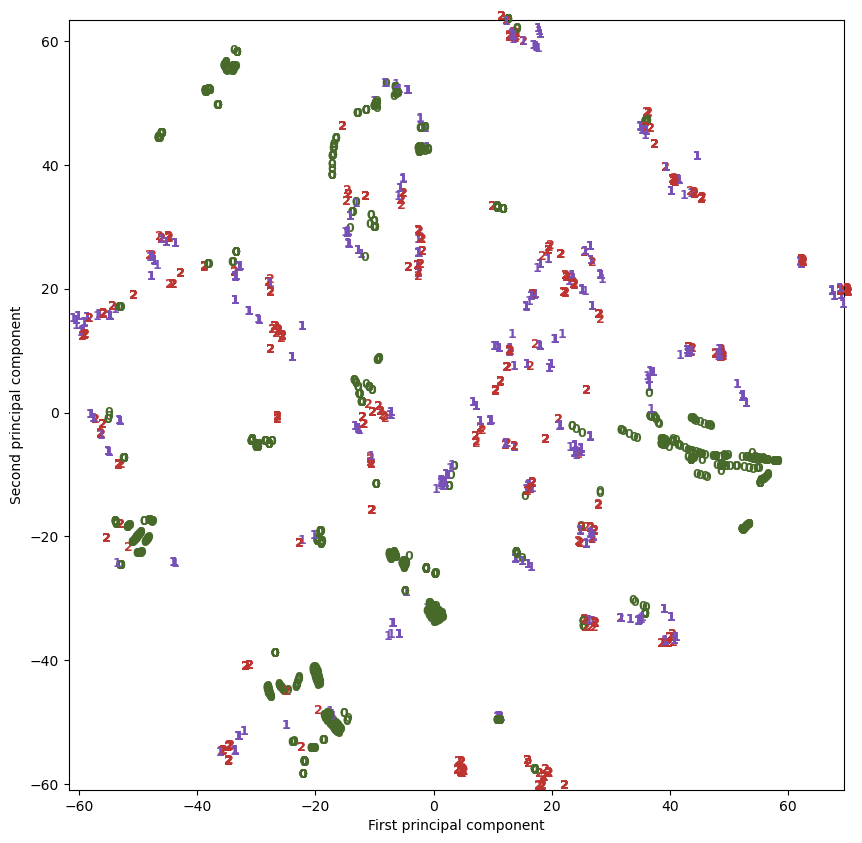

In [186]:
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
plt.figure(figsize=(10, 10))
plt.xlim(tsne_data[:, 0].min(), tsne_data[:, 0].max())
plt.ylim(tsne_data[:, 1].min(), tsne_data[:, 1].max())
for i in range(len(to_cluster_df)):
    # actually plot the digits as text instead of using scatter
    plt.text(tsne_data[i, 0], tsne_data[i, 1], str(list(to_cluster_df['cluster'])[i]),
             color = colors[list(to_cluster_df['cluster'])[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
#상대적으로 잘 뭉쳐져있다! -> 시각화하는데 잘 사용됨.

- 잘 나눠졌는지 모르겠어서, 3차원으로 확인

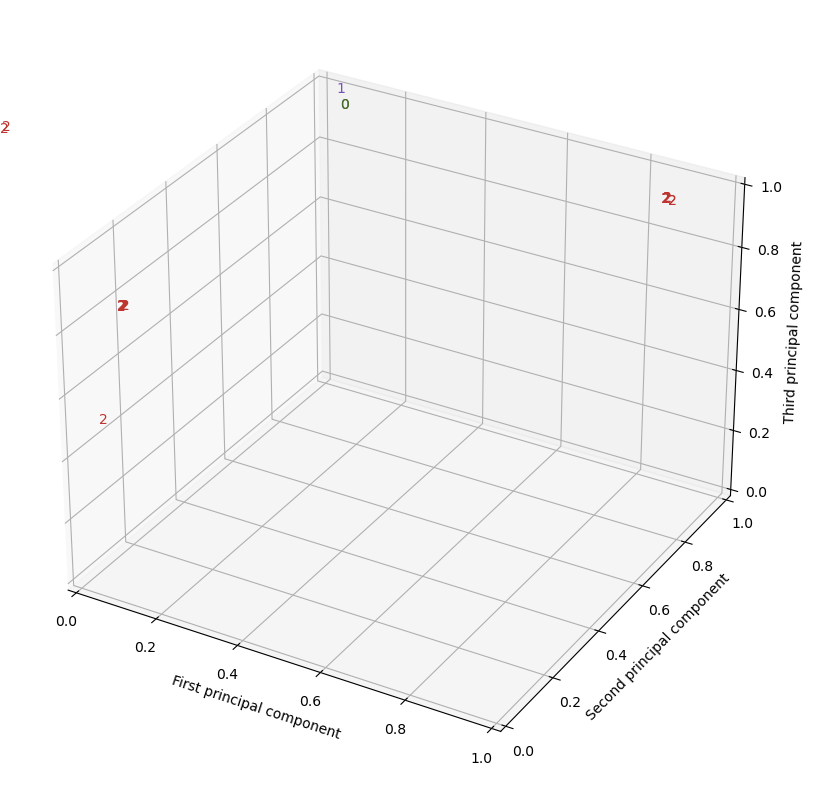

In [187]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x_data = to_cluster_df.drop(columns=['index','disk_id','label','cluster'])

# Reduce dimensions with t-SNE
tsne = TSNE(n_components=3, random_state=42) # set n_components to 3 for 3D
tsne_data = tsne.fit_transform(x_data)

colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]

# Create a 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(to_cluster_df)):
    ax.text(tsne_data[i, 0], tsne_data[i, 1], tsne_data[i, 2], str(list(to_cluster_df['cluster'])[i]),
             color = colors[list(to_cluster_df['cluster'])[i]])

ax.set_xlabel("First principal component")
ax.set_ylabel("Second principal component")
ax.set_zlabel("Third principal component")
plt.show()

- 0,1이 같이 묶일 줄 알았는데, 오히려 원래 2,3이 하나로 묶임..뭐지??
- 각 feature에 대한 plot을 통해, 각 클러스터별 양상을 비교해보니, 원래 0,1은 그대로 묶이고, 2,3이 합쳐진 모습을 확인 가능(2,3의 평균 => 2)

묶인 cluster에 대해서, 분석해보면 좋을듯. 예를 들어, 어떤 feature에서는 다른 양상을 보인다..등등

In [ ]:
from sklearn.metrics import silhouette_score
inertia=[]
kmeans_sil_scores=[]
for n_cluster in range(2,14):
    kmeans = KMeans(n_clusters=n_cluster, random_state=0)
    cluster_labels = kmeans.fit_predict(label_1_scaled)

    inertia.append(kmeans.inertia_)
    kmeans_sil_scores.append(silhouette_score(label_1_scaled, cluster_labels))

plt.plot(range(2,14),inertia,marker='o', lw=1,ms=10) 
plt.xlabel("Number of clusters")
plt.title("K-Means Inertia")
# clusters = 3일때, 꺽이는 지점인것을 알 수 있음

### Euclidean_kmeans

In [13]:
# Scale the data
scaler = TimeSeriesScalerMeanVariance()
data_scaled = scaler.fit_transform(to_cluster)

In [31]:
def calculate_scores(num_clusters, data_scaled):
    km_dtw = TimeSeriesKMeans(n_clusters=num_clusters, metric="euclidean")
    clusters = km_dtw.fit_predict(data_scaled)
    silhouette = silhouette_score(data_scaled.reshape(data_scaled.shape[0], -1), clusters)
    inertia = km_dtw.inertia_
    return silhouette, inertia

In [32]:
num_clusters_range = range(2, 11)
silhouette_scores = []
inertia_scores = []

for k in num_clusters_range:
    silhouette, inertia = calculate_scores(k, data_scaled)
    silhouette_scores.append(silhouette)
    inertia_scores.append(inertia)

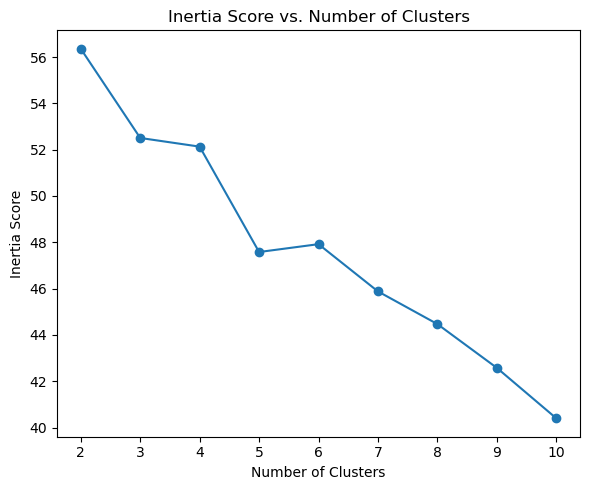

In [33]:
# Plot only the Inertia Score vs. Number of Clusters
plt.figure(figsize=(6, 5))
plt.plot(num_clusters_range, inertia_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia Score")
plt.title("Inertia Score vs. Number of Clusters")
plt.tight_layout()
plt.show()

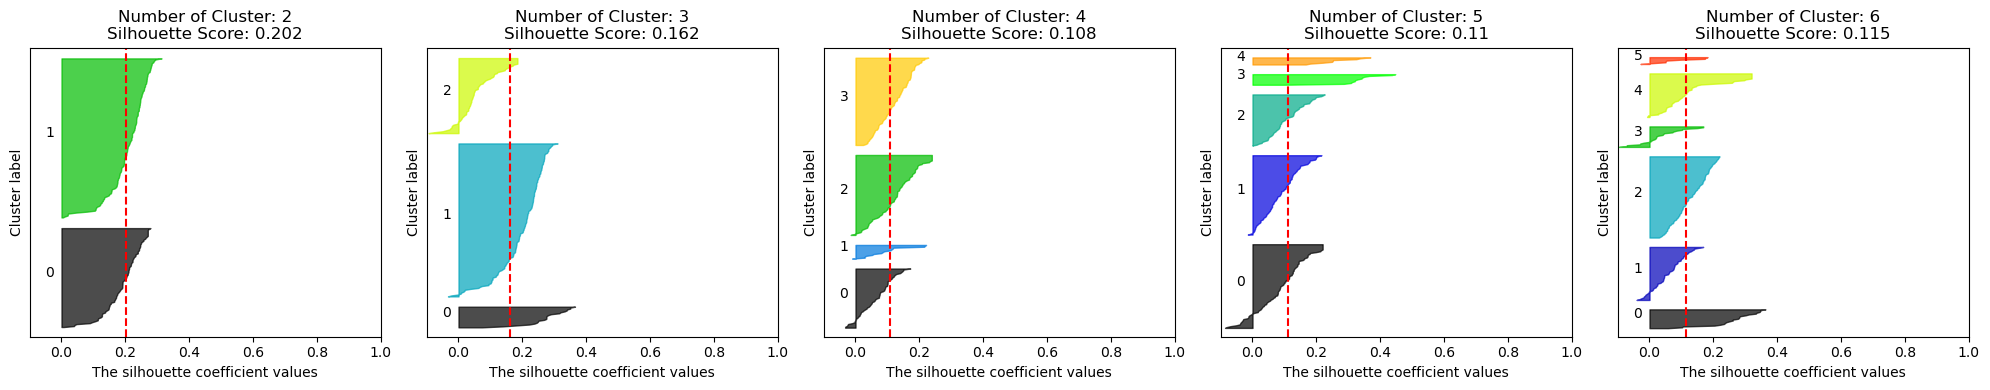

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.metrics import silhouette_score, silhouette_samples

# Assuming you have already scaled your time series data (data_scaled) using TimeSeriesScalerMeanVariance
def visualize_silhouette(cluster_lists, data_scaled):
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4 * n_cols, 4), nrows=1, ncols=n_cols)

    # Flatten the 3-dimensional time series data into 2-dimensional array
    data_reshaped = data_scaled.reshape(data_scaled.shape[0], -1)

    for ind, n_cluster in enumerate(cluster_lists):
        km_dtw = TimeSeriesKMeans(n_clusters=n_cluster, metric="euclidean", verbose=False)
        clusters = km_dtw.fit_predict(data_scaled)

        # Calculate the silhouette score on the reshaped data
        silhouette_avg = silhouette_score(data_reshaped, clusters)

        sample_silhouette_values = silhouette_samples(data_reshaped, clusters)
        y_lower = 10

        axs[ind].set_title('Number of Cluster: ' + str(n_cluster) + '\n'
                          'Silhouette Score: ' + str(round(silhouette_avg, 3)))
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(data_scaled) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        for i in range(n_cluster):
            ith_cluster_sil_values = sample_silhouette_values[clusters == i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = plt.cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values,
                                   facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=silhouette_avg, color="red", linestyle="--")

# Example usage with your data_scaled (assuming it's a NumPy array of time series data)
visualize_silhouette(range(2, 7), data_scaled)
plt.tight_layout()
plt.show()

In [35]:
# Choose the number of clusters (k) you want
k = 3

# Run the TimeSeriesKMeans algorithm with DTW distance
km_dtw = TimeSeriesKMeans(n_clusters=k, metric="euclidean")
clusters = km_dtw.fit_predict(data_scaled)

In [36]:
clusters

array([2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 1, 2,
       1, 0, 0, 1, 2, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 2, 2, 1, 0, 0, 0, 1, 1, 1, 0, 2, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2, 1, 2, 1, 0, 0, 0, 1, 2, 2, 2, 1,
       0, 1, 2, 1, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2,
       1, 2, 0, 0, 2, 1, 1, 2, 2, 0, 2, 2, 0, 0, 1, 0, 1, 1, 1, 0, 2, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 2, 1, 0, 2, 2, 0, 1, 1, 2, 2, 0, 1, 0, 0,
       0, 0, 2, 2], dtype=int64)

In [37]:
to_cluster_df = to_cluster_data.copy()
to_cluster_df.reset_index(inplace=True,drop=True)

to_cluster_df['cluster']=0
for i, cluster in enumerate(clusters):
    to_cluster_df.loc[i*10:i*10+10, 'cluster'] = cluster
to_cluster_df

,index,disk_id,n_5,r_5,n_9,r_9,n_12,r_12,n_177,r_177,...,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,label,cluster
0,2019-03-16,470.0,99.0,4.0,96.0,16054.0,99.0,18.0,99.0,7.0,...,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.743607e+09,0.0,2
1,2019-03-17,470.0,99.0,4.0,96.0,16078.0,99.0,18.0,99.0,7.0,...,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.744597e+09,0.0,2
2,2019-03-18,470.0,99.0,4.0,96.0,16102.0,99.0,18.0,99.0,7.0,...,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.745809e+09,0.0,2
3,2019-03-19,470.0,99.0,4.0,96.0,16126.0,99.0,18.0,99.0,7.0,...,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.747037e+09,0.0,2
4,2019-03-20,470.0,99.0,4.0,96.0,16150.0,99.0,18.0,99.0,7.0,...,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.748307e+09,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2675,2019-03-21,44338.0,99.0,2.0,96.0,16176.0,99.0,21.0,99.0,6.0,...,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.778025e+09,0.0,2
2676,2019-03-22,44338.0,99.0,2.0,96.0,16200.0,99.0,21.0,99.0,6.0,...,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.779657e+09,0.0,2
2677,2019-03-23,44338.0,99.0,2.0,96.0,16224.0,99.0,21.0,99.0,6.0,...,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.781085e+09,0.0,2
2678,2019-03-24,44338.0,99.0,2.0,96.0,16248.0,99.0,21.0,99.0,6.0,...,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.782419e+09,0.0,2


In [38]:
df = to_cluster_df.drop(columns=['index','label'])

cluster_0 = df[df['cluster']==0].drop('cluster',axis=1).copy()
cluster_1 = df[df['cluster']==1].drop('cluster',axis=1).copy()
cluster_2 = df[df['cluster']==2].drop('cluster',axis=1).copy()
""" cluster_3 = df[df['cluster']==3].drop('cluster',axis=1).copy()
cluster_4 = df[df['cluster']==4].drop('cluster',axis=1).copy() """

cluster_0_grouped = cluster_0.groupby(['disk_id']).apply(np.array)
cluster_1_grouped = cluster_1.groupby(['disk_id']).apply(np.array)
cluster_2_grouped = cluster_2.groupby(['disk_id']).apply(np.array)
""" cluster_3_grouped = cluster_3.groupby(['disk_id']).apply(np.array)
cluster_4_grouped = cluster_4.groupby(['disk_id']).apply(np.array) """

cluster_0_arr = np.array(cluster_0_grouped.tolist())  # This is now a 3D groupby (n_samples, n_timestamps, n_features)
cluster_1_arr = np.array(cluster_1_grouped.tolist())
cluster_2_arr = np.array(cluster_2_grouped.tolist())
""" cluster_3_arr = np.array(cluster_3_grouped.tolist())
cluster_4_arr = np.array(cluster_4_grouped.tolist())
 """
print('cluster_0_arr 의 shpae:',cluster_0_arr.shape)
print('cluster_1_arr 의 shpae:',cluster_1_arr.shape)
print('cluster_2_arr 의 shpae:',cluster_2_arr.shape)
""" print('cluster_3_arr 의 shpae:',cluster_3_arr.shape)
print('cluster_4_arr 의 shpae:',cluster_4_arr.shape) """

cluster_0_arr 의 shpae: (164, 10, 33)
cluster_1_arr 의 shpae: (54, 10, 33)
cluster_2_arr 의 shpae: (50, 10, 33)


" print('cluster_3_arr 의 shpae:',cluster_3_arr.shape)\nprint('cluster_4_arr 의 shpae:',cluster_4_arr.shape) "

In [39]:
import numpy as np

# Calculate the mean along the first axis
cluster_0_mean_data = np.mean(cluster_0_arr, axis=0)
cluster_1_mean_data = np.mean(cluster_1_arr, axis=0)
cluster_2_mean_data = np.mean(cluster_2_arr, axis=0)
""" cluster_3_mean_data = np.mean(cluster_3_arr, axis=0)
cluster_4_mean_data = np.mean(cluster_4_arr, axis=0) """

# Now 'mean_data' has shape (10, 33)
print(cluster_0_mean_data.shape)  # Output: (10, 33)

(10, 33)


In [40]:
cluster_0_mean_df = pd.DataFrame(cluster_0_mean_data, columns=cluster_0.columns)
del(cluster_0_mean_df['disk_id'])

cluster_1_mean_df = pd.DataFrame(cluster_1_mean_data, columns=cluster_1.columns)
del(cluster_1_mean_df['disk_id'])

cluster_2_mean_df = pd.DataFrame(cluster_2_mean_data, columns=cluster_2.columns)
del(cluster_2_mean_df['disk_id'])

""" cluster_3_mean_df = pd.DataFrame(cluster_3_mean_data, columns=cluster_3.columns)
del(cluster_3_mean_df['disk_id'])

cluster_4_mean_df = pd.DataFrame(cluster_4_mean_data, columns=cluster_4.columns)
del(cluster_4_mean_df['disk_id']) """

" cluster_3_mean_df = pd.DataFrame(cluster_3_mean_data, columns=cluster_3.columns)\ndel(cluster_3_mean_df['disk_id'])\n\ncluster_4_mean_df = pd.DataFrame(cluster_4_mean_data, columns=cluster_4.columns)\ndel(cluster_4_mean_df['disk_id']) "

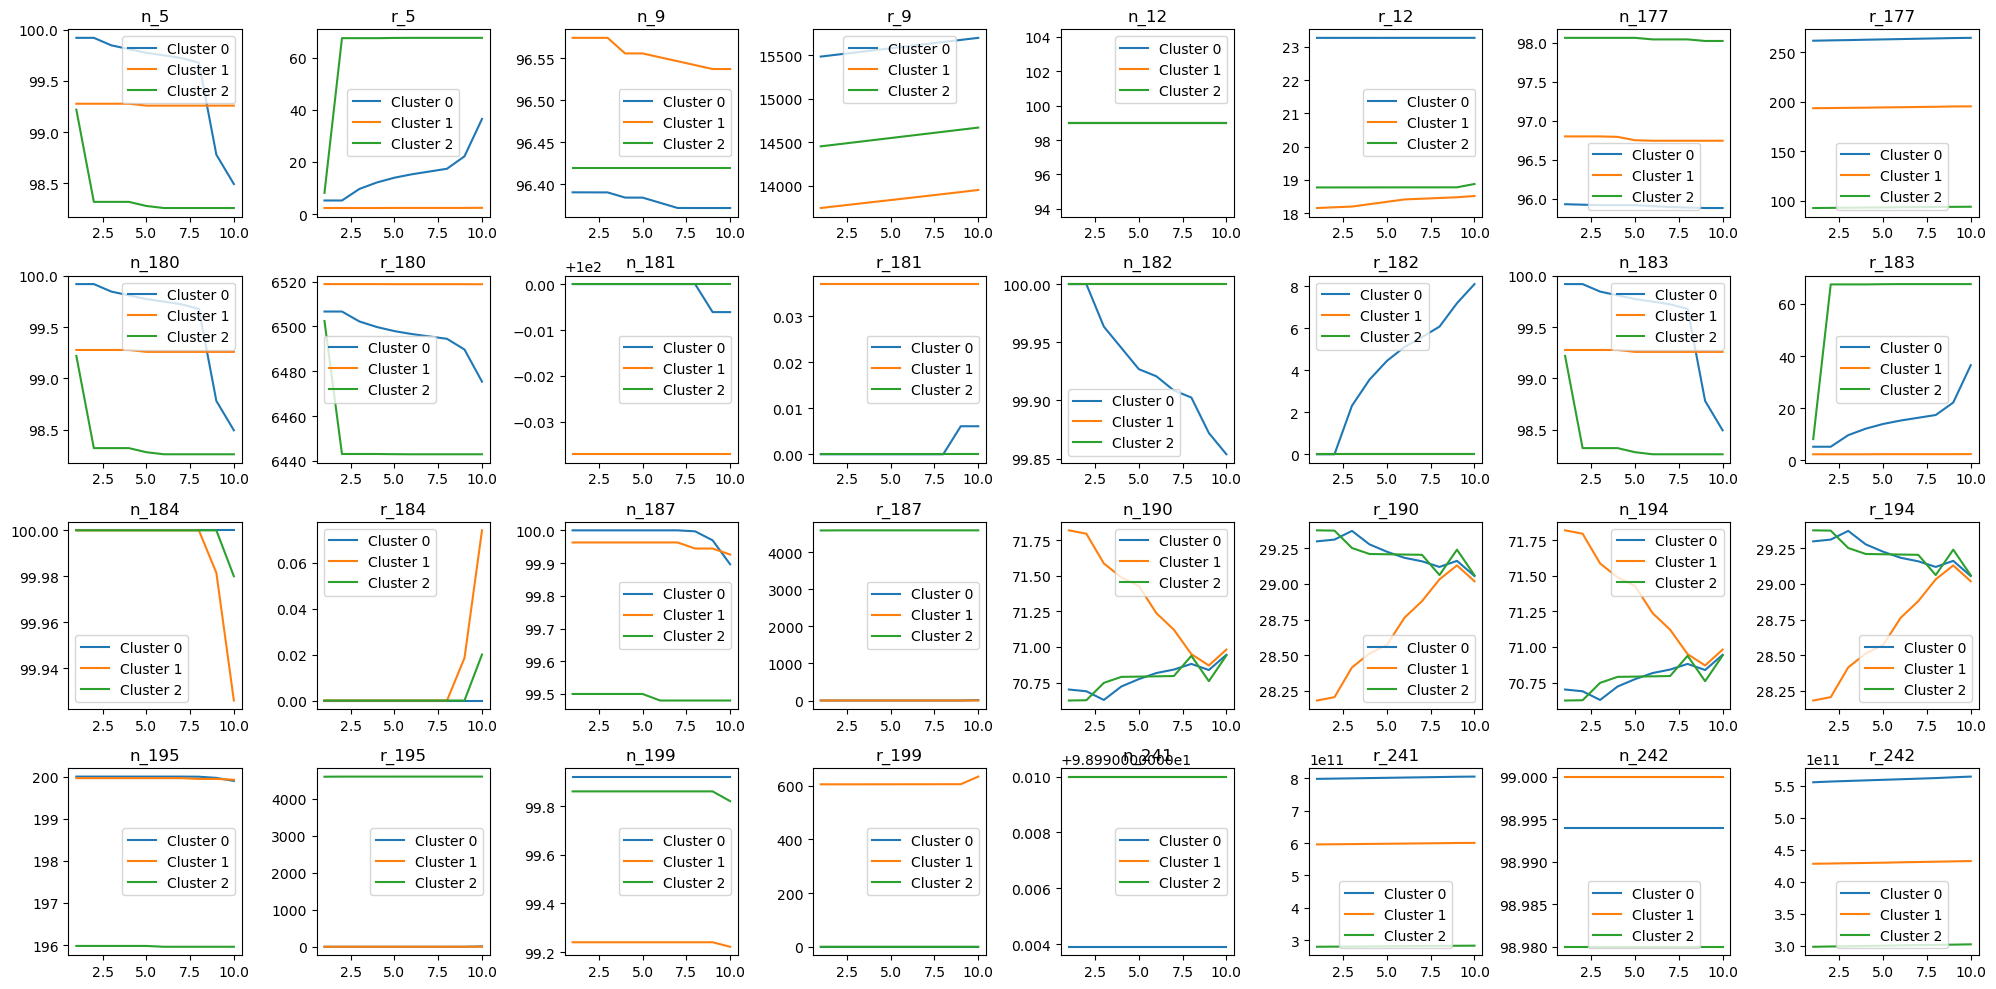

In [41]:
import matplotlib.pyplot as plt

# Assuming the dataframes are named 'cluster_0_mean_df', 'cluster_1_mean_df', 'cluster_2_mean_df', 'cluster_3_mean_df'
clusters = [cluster_0_mean_df, cluster_1_mean_df, cluster_2_mean_df]
cluster_names = ['Cluster 0', 'Cluster 1', 'Cluster 2']

# feature names list
feature_names = cluster_0_mean_df.columns.tolist()

# Create subplots with 4 rows and 8 columns, each cell will represent a feature
fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(20, 10))

# Reshape the axes array to 1D for easy iteration
axs = axs.ravel()

for i in range(len(feature_names)):
    for j in range(3):
        # Plot each cluster's line in the same subplot (feature)
        axs[i].plot(clusters[j].index + 1, clusters[j].iloc[:, i], label=cluster_names[j])
        
    axs[i].set_title(feature_names[i])
    axs[i].legend()

plt.tight_layout()
plt.show()

### DTW Kmeans

In [42]:
to_cluster = to_cluster_data.drop(columns=['index','label'])

grouped = to_cluster.groupby("disk_id").apply(np.array)

to_cluster = np.array(grouped.tolist())  # This is now a 3D array (n_samples, n_timestamps, n_features)
to_cluster = to_cluster[:, :, 1:]
to_cluster.shape

(268, 10, 32)

In [43]:
# Scale the data
scaler = TimeSeriesScalerMeanVariance()
data_scaled = scaler.fit_transform(to_cluster)

In [44]:
def calculate_scores(num_clusters, data_scaled):
    km_dtw = TimeSeriesKMeans(n_clusters=num_clusters, metric="dtw")
    clusters = km_dtw.fit_predict(data_scaled)
    silhouette = silhouette_score(data_scaled.reshape(data_scaled.shape[0], -1), clusters)
    inertia = km_dtw.inertia_
    return silhouette, inertia

In [45]:
num_clusters_range = range(2, 11)
silhouette_scores = []
inertia_scores = []

for k in num_clusters_range:
    silhouette, inertia = calculate_scores(k, data_scaled)
    silhouette_scores.append(silhouette)
    inertia_scores.append(inertia)

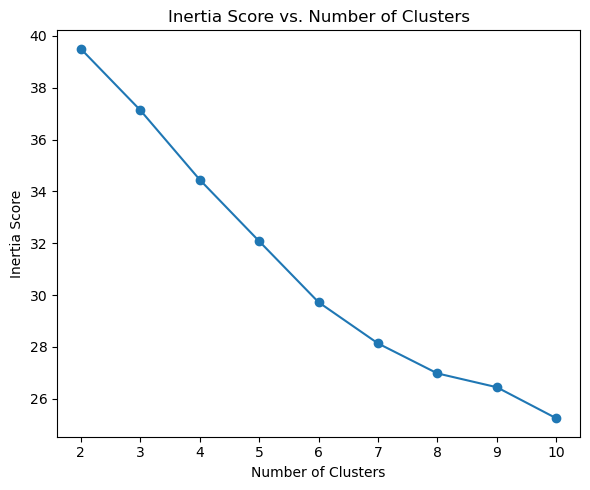

In [46]:
# Plot only the Inertia Score vs. Number of Clusters
plt.figure(figsize=(6, 5))
plt.plot(num_clusters_range, inertia_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia Score")
plt.title("Inertia Score vs. Number of Clusters")
plt.tight_layout()
plt.show()

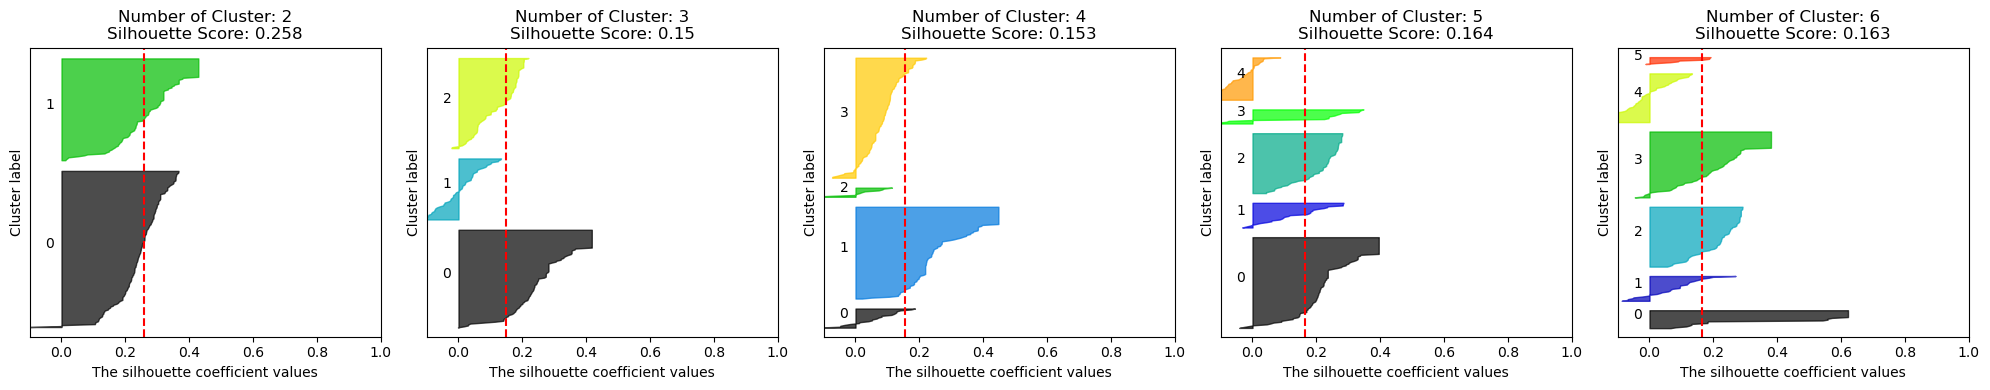

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.metrics import silhouette_score, silhouette_samples

# Assuming you have already scaled your time series data (data_scaled) using TimeSeriesScalerMeanVariance
def visualize_silhouette(cluster_lists, data_scaled):
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4 * n_cols, 4), nrows=1, ncols=n_cols)

    # Flatten the 3-dimensional time series data into 2-dimensional array
    data_reshaped = data_scaled.reshape(data_scaled.shape[0], -1)

    for ind, n_cluster in enumerate(cluster_lists):
        km_dtw = TimeSeriesKMeans(n_clusters=n_cluster, metric="dtw", verbose=False)
        clusters = km_dtw.fit_predict(data_scaled)

        # Calculate the silhouette score on the reshaped data
        silhouette_avg = silhouette_score(data_reshaped, clusters)

        sample_silhouette_values = silhouette_samples(data_reshaped, clusters)
        y_lower = 10

        axs[ind].set_title('Number of Cluster: ' + str(n_cluster) + '\n'
                          'Silhouette Score: ' + str(round(silhouette_avg, 3)))
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(data_scaled) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        for i in range(n_cluster):
            ith_cluster_sil_values = sample_silhouette_values[clusters == i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = plt.cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values,
                                   facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=silhouette_avg, color="red", linestyle="--")

# Example usage with your data_scaled (assuming it's a NumPy array of time series data)
visualize_silhouette(range(2, 7), data_scaled)
plt.tight_layout()
plt.show()

In [56]:
# Choose the number of clusters (k) you want
k = 2

# Run the TimeSeriesKMeans algorithm with DTW distance
km_dtw = TimeSeriesKMeans(n_clusters=k, metric="dtw")
clusters = km_dtw.fit_predict(data_scaled)

In [57]:
clusters

array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 1], dtype=int64)

In [58]:
to_cluster_df = to_cluster_data.copy()
to_cluster_df.reset_index(inplace=True,drop=True)

to_cluster_df['cluster']=0
for i, cluster in enumerate(clusters):
    to_cluster_df.loc[i*10:i*10+10, 'cluster'] = cluster
to_cluster_df

,index,disk_id,n_5,r_5,n_9,r_9,n_12,r_12,n_177,r_177,...,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,label,cluster
0,2019-03-16,470.0,99.0,4.0,96.0,16054.0,99.0,18.0,99.0,7.0,...,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.743607e+09,0.0,1
1,2019-03-17,470.0,99.0,4.0,96.0,16078.0,99.0,18.0,99.0,7.0,...,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.744597e+09,0.0,1
2,2019-03-18,470.0,99.0,4.0,96.0,16102.0,99.0,18.0,99.0,7.0,...,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.745809e+09,0.0,1
3,2019-03-19,470.0,99.0,4.0,96.0,16126.0,99.0,18.0,99.0,7.0,...,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.747037e+09,0.0,1
4,2019-03-20,470.0,99.0,4.0,96.0,16150.0,99.0,18.0,99.0,7.0,...,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.748307e+09,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2675,2019-03-21,44338.0,99.0,2.0,96.0,16176.0,99.0,21.0,99.0,6.0,...,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.778025e+09,0.0,1
2676,2019-03-22,44338.0,99.0,2.0,96.0,16200.0,99.0,21.0,99.0,6.0,...,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.779657e+09,0.0,1
2677,2019-03-23,44338.0,99.0,2.0,96.0,16224.0,99.0,21.0,99.0,6.0,...,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.781085e+09,0.0,1
2678,2019-03-24,44338.0,99.0,2.0,96.0,16248.0,99.0,21.0,99.0,6.0,...,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.782419e+09,0.0,1


In [59]:
df = to_cluster_df.drop(columns=['index','label'])

cluster_0 = df[df['cluster']==0].drop('cluster',axis=1).copy()
cluster_1 = df[df['cluster']==1].drop('cluster',axis=1).copy()
#cluster_2 = df[df['cluster']==2].drop('cluster',axis=1).copy()
""" cluster_3 = df[df['cluster']==3].drop('cluster',axis=1).copy()
cluster_4 = df[df['cluster']==4].drop('cluster',axis=1).copy() """

cluster_0_grouped = cluster_0.groupby(['disk_id']).apply(np.array)
cluster_1_grouped = cluster_1.groupby(['disk_id']).apply(np.array)
#cluster_2_grouped = cluster_2.groupby(['disk_id']).apply(np.array)
""" cluster_3_grouped = cluster_3.groupby(['disk_id']).apply(np.array)
cluster_4_grouped = cluster_4.groupby(['disk_id']).apply(np.array) """

cluster_0_arr = np.array(cluster_0_grouped.tolist())  # This is now a 3D groupby (n_samples, n_timestamps, n_features)
cluster_1_arr = np.array(cluster_1_grouped.tolist())
#cluster_2_arr = np.array(cluster_2_grouped.tolist())
""" cluster_3_arr = np.array(cluster_3_grouped.tolist())
cluster_4_arr = np.array(cluster_4_grouped.tolist())
 """
print('cluster_0_arr 의 shpae:',cluster_0_arr.shape)
print('cluster_1_arr 의 shpae:',cluster_1_arr.shape)
#print('cluster_2_arr 의 shpae:',cluster_2_arr.shape)
""" print('cluster_3_arr 의 shpae:',cluster_3_arr.shape)
print('cluster_4_arr 의 shpae:',cluster_4_arr.shape) """

cluster_0_arr 의 shpae: (161, 10, 33)
cluster_1_arr 의 shpae: (107, 10, 33)


" print('cluster_3_arr 의 shpae:',cluster_3_arr.shape)\nprint('cluster_4_arr 의 shpae:',cluster_4_arr.shape) "

In [60]:
import numpy as np

# Calculate the mean along the first axis
cluster_0_mean_data = np.mean(cluster_0_arr, axis=0)
cluster_1_mean_data = np.mean(cluster_1_arr, axis=0)
cluster_2_mean_data = np.mean(cluster_2_arr, axis=0)
""" cluster_3_mean_data = np.mean(cluster_3_arr, axis=0)
cluster_4_mean_data = np.mean(cluster_4_arr, axis=0) """

# Now 'mean_data' has shape (10, 33)
print(cluster_0_mean_data.shape)  # Output: (10, 33)

(10, 33)


In [61]:
cluster_0_mean_df = pd.DataFrame(cluster_0_mean_data, columns=cluster_0.columns)
del(cluster_0_mean_df['disk_id'])

cluster_1_mean_df = pd.DataFrame(cluster_1_mean_data, columns=cluster_1.columns)
del(cluster_1_mean_df['disk_id'])

cluster_2_mean_df = pd.DataFrame(cluster_2_mean_data, columns=cluster_2.columns)
del(cluster_2_mean_df['disk_id'])

""" cluster_3_mean_df = pd.DataFrame(cluster_3_mean_data, columns=cluster_3.columns)
del(cluster_3_mean_df['disk_id'])

cluster_4_mean_df = pd.DataFrame(cluster_4_mean_data, columns=cluster_4.columns)
del(cluster_4_mean_df['disk_id']) """

" cluster_3_mean_df = pd.DataFrame(cluster_3_mean_data, columns=cluster_3.columns)\ndel(cluster_3_mean_df['disk_id'])\n\ncluster_4_mean_df = pd.DataFrame(cluster_4_mean_data, columns=cluster_4.columns)\ndel(cluster_4_mean_df['disk_id']) "

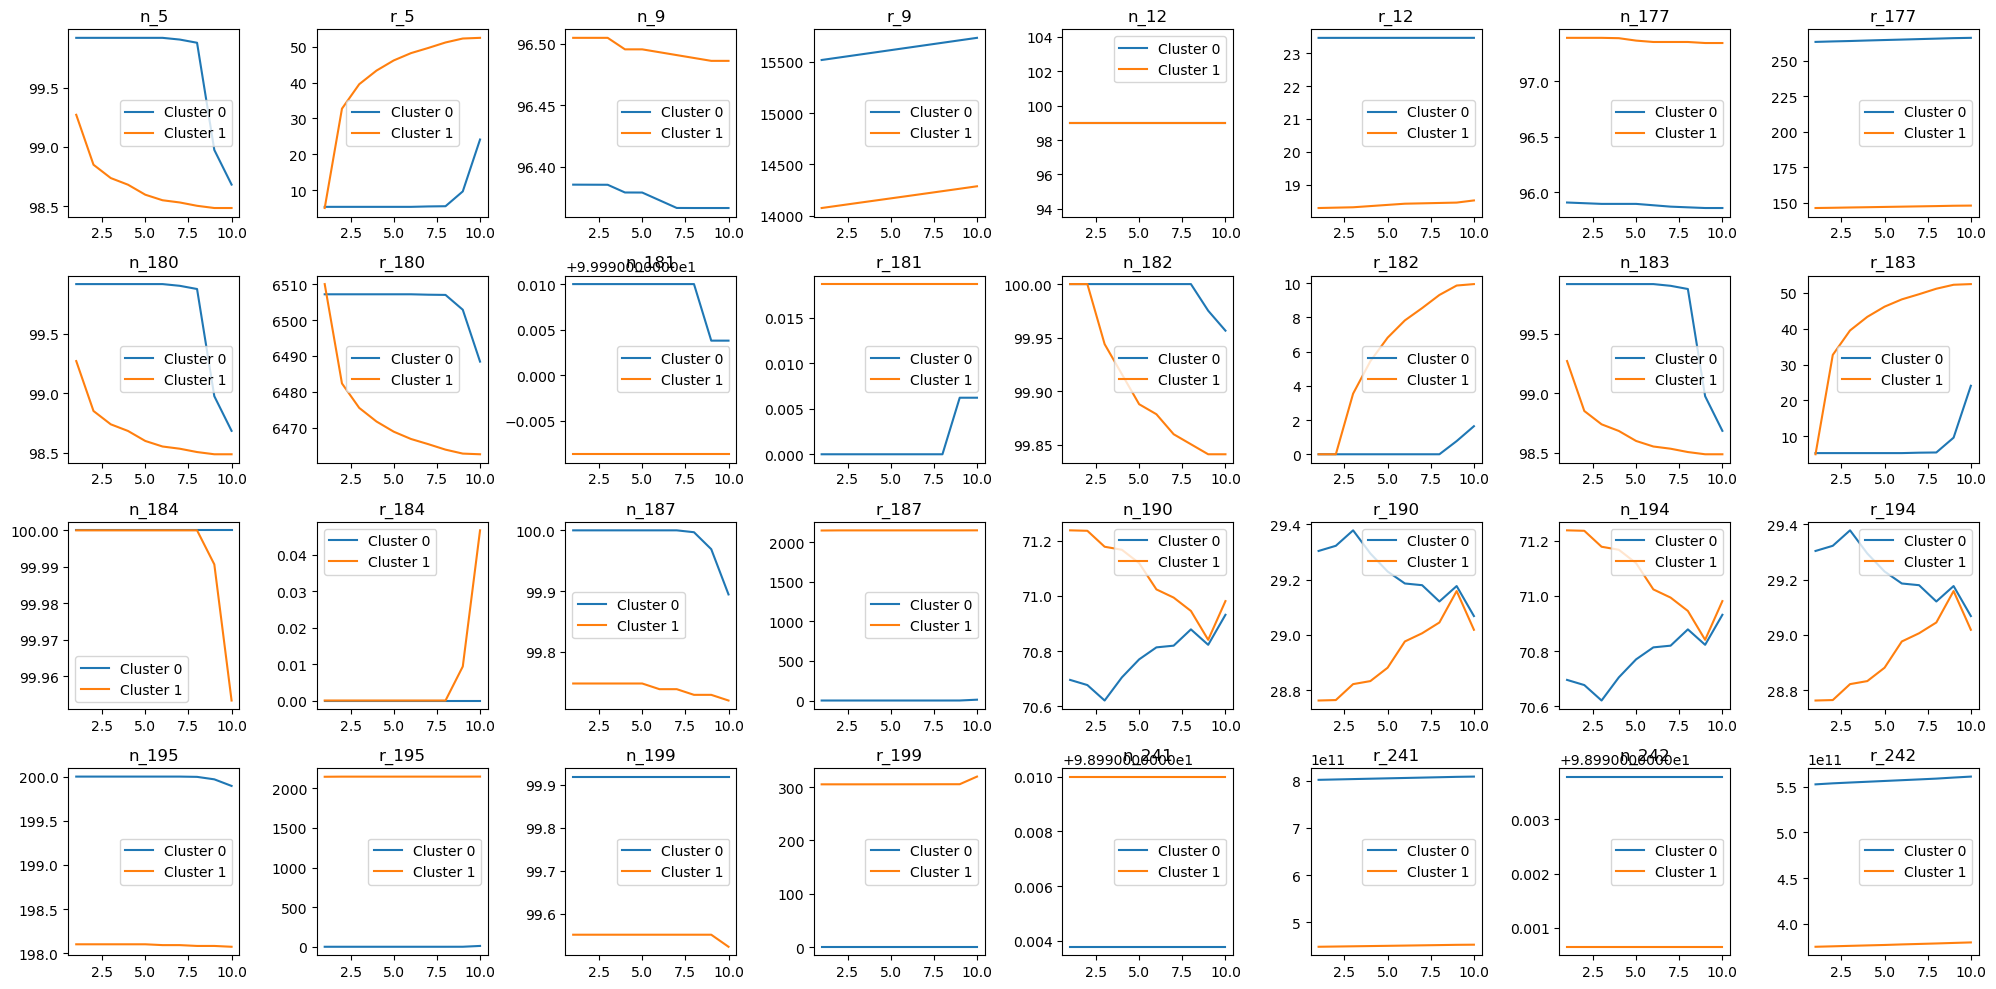

In [63]:
import matplotlib.pyplot as plt

# Assuming the dataframes are named 'cluster_0_mean_df', 'cluster_1_mean_df', 'cluster_2_mean_df', 'cluster_3_mean_df'
clusters = [cluster_0_mean_df, cluster_1_mean_df]
cluster_names = ['Cluster 0', 'Cluster 1']

# feature names list
feature_names = cluster_0_mean_df.columns.tolist()

# Create subplots with 4 rows and 8 columns, each cell will represent a feature
fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(20, 10))

# Reshape the axes array to 1D for easy iteration
axs = axs.ravel()

for i in range(len(feature_names)):
    for j in range(2):
        # Plot each cluster's line in the same subplot (feature)
        axs[i].plot(clusters[j].index + 1, clusters[j].iloc[:, i], label=cluster_names[j])
        
    axs[i].set_title(feature_names[i])
    axs[i].legend()

plt.tight_layout()
plt.show()

# 옛날에 한거임, 쓸모없을수도있어서 접어둠

In [4]:
#Scaling 과정
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(label_1)
label_1_scaled = scaler.transform(label_1)

c:\Users\choib\anaconda3\envs\iise-python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\choib\anaconda3\envs\iise-python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\choib\anaconda3\envs\iise-python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\choib\anaconda3\envs\iise-python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  war

Text(0.5, 1.0, 'K-Means Inertia')

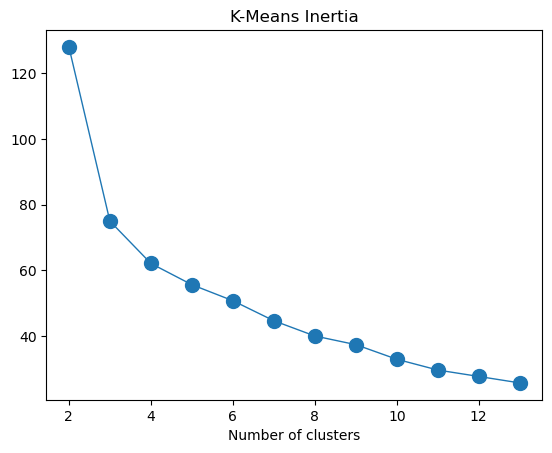

In [5]:
from sklearn.metrics import silhouette_score

from sklearn.cluster import KMeans
'''StandardSclaer를 사용하여 진행''' 

inertia=[]
kmeans_sil_scores=[]
for n_cluster in range(2,14):
    kmeans = KMeans(n_clusters=n_cluster, random_state=0)
    cluster_labels = kmeans.fit_predict(label_1_scaled)

    inertia.append(kmeans.inertia_)
    kmeans_sil_scores.append(silhouette_score(label_1_scaled, cluster_labels))

plt.plot(range(2,14),inertia,marker='o', lw=1,ms=10) 
plt.xlabel("Number of clusters")
plt.title("K-Means Inertia")
# clusters = 3일때, 꺽이는 지점인것을 알 수 있음

Text(0.5, 1.0, 'Silhouette Score')

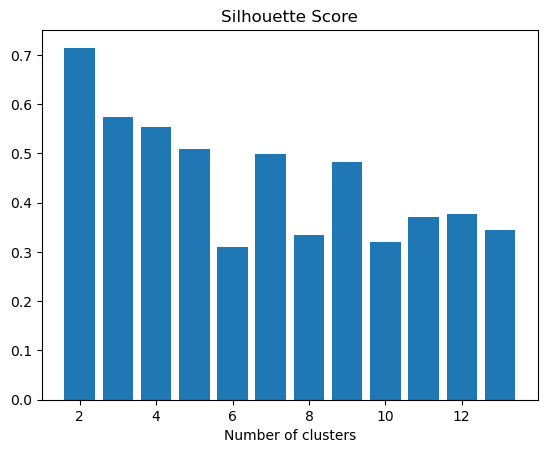

In [6]:
plt.bar(range(2,14),kmeans_sil_scores,)
plt.xlabel("Number of clusters")
plt.title("Silhouette Score")
# clusters =3 일때, silhouette score가 가장 높은것을 알 수 있음.

In [50]:
n_cluster=2
best_kmeans = KMeans(n_clusters=n_cluster,random_state=0)
cluster_labels=best_kmeans.fit_predict(label_1_scaled)
best_kmeans_sil_score=silhouette_score(label_1_scaled,cluster_labels)

print('Best kmeans clustering silhouette score:',best_kmeans_sil_score)

Best kmeans clustering silhouette score: 0.7144534943579282


c:\Users\choib\anaconda3\envs\iise-python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [51]:
label_1['cluster']=cluster_labels
label_1

,r_1,n_5,r_5,r_9,r_12,n_171,r_171,n_172,r_172,n_173,...,r_194,r_195,n_196,r_196,r_197,r_198,r_199,n_175,r_175,cluster
476,4.294967e+09,98.0,2.0,40175.0,28.0,100.0,4.0,100.0,0.0,1.0,...,20.0,1.067805e+09,99.0,2.0,0.0,0.0,0.0,100.0,1.018337e+12,0
486,4.294967e+09,98.0,0.0,40012.0,59.0,100.0,0.0,100.0,0.0,1.0,...,16.0,2.260676e+09,100.0,0.0,0.0,0.0,0.0,100.0,1.005077e+12,0
1336,4.294967e+09,98.0,0.0,36922.0,30.0,100.0,0.0,100.0,0.0,1.0,...,18.0,1.591232e+09,100.0,0.0,0.0,0.0,0.0,100.0,9.407059e+11,0
1342,4.294967e+09,98.0,0.0,36522.0,28.0,100.0,0.0,100.0,0.0,83.0,...,14.0,2.791970e+08,100.0,0.0,0.0,0.0,0.0,100.0,9.280304e+11,0
1403,4.294967e+09,94.0,141.0,37481.0,30.0,99.0,70.0,100.0,0.0,1.0,...,8.0,2.748596e+09,97.0,141.0,0.0,0.0,0.0,100.0,9.497040e+11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64872,4.294967e+09,96.0,0.0,44625.0,36.0,100.0,0.0,100.0,0.0,97.0,...,15.0,1.270160e+06,100.0,0.0,0.0,0.0,0.0,1.0,1.134050e+12,0
65353,4.294967e+09,98.0,0.0,44244.0,27.0,100.0,0.0,100.0,0.0,1.0,...,19.0,2.581993e+09,100.0,0.0,0.0,0.0,0.0,100.0,1.125316e+12,0
65429,4.294967e+09,98.0,0.0,40585.0,28.0,100.0,0.0,100.0,0.0,1.0,...,15.0,1.579518e+09,100.0,0.0,0.0,0.0,0.0,100.0,1.035432e+12,0
65911,4.294967e+09,98.0,0.0,42078.0,44.0,100.0,0.0,100.0,0.0,1.0,...,17.0,3.873290e+09,100.0,0.0,0.0,0.0,0.0,100.0,1.057160e+12,0


In [52]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(label_1)
label_1_pca = pca.transform(label_1)

In [53]:
# dim reduction with tsne
tsne = TSNE(random_state=42)
# use fit_transform instead of fit, as TSNE has no transform method. not be used as preprocessing step of supervised learning
label_1_tsne = tsne.fit_transform(label_1)

Text(0, 0.5, 'Second principal component')

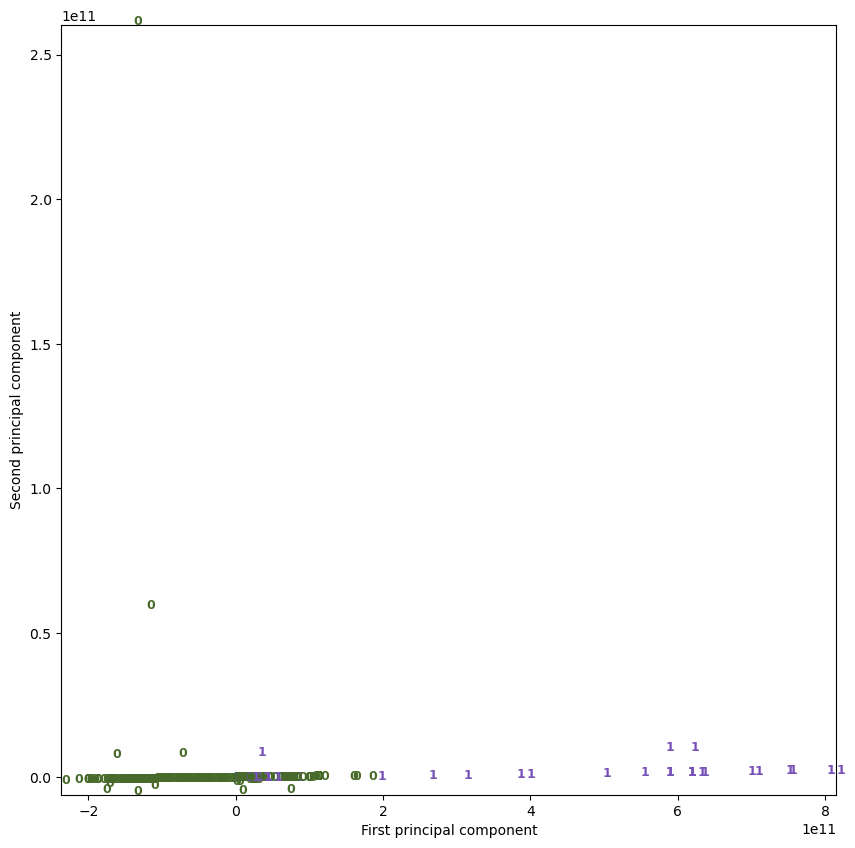

In [54]:
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
plt.figure(figsize=(10, 10))
plt.xlim(label_1_pca[:, 0].min(), label_1_pca[:, 0].max())
plt.ylim(label_1_pca[:, 1].min(), label_1_pca[:, 1].max())
for i in range(len(label_1)):
    # actually plot the digits as text instead of using scatter
    plt.text(label_1_pca[i, 0], label_1_pca[i, 1], str(list(label_1['cluster'])[i]),
             color = colors[list(label_1['cluster'])[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
#중복되는 경우 많음. 난잡하게 섞여있다.

Text(0, 0.5, 'Second principal component')

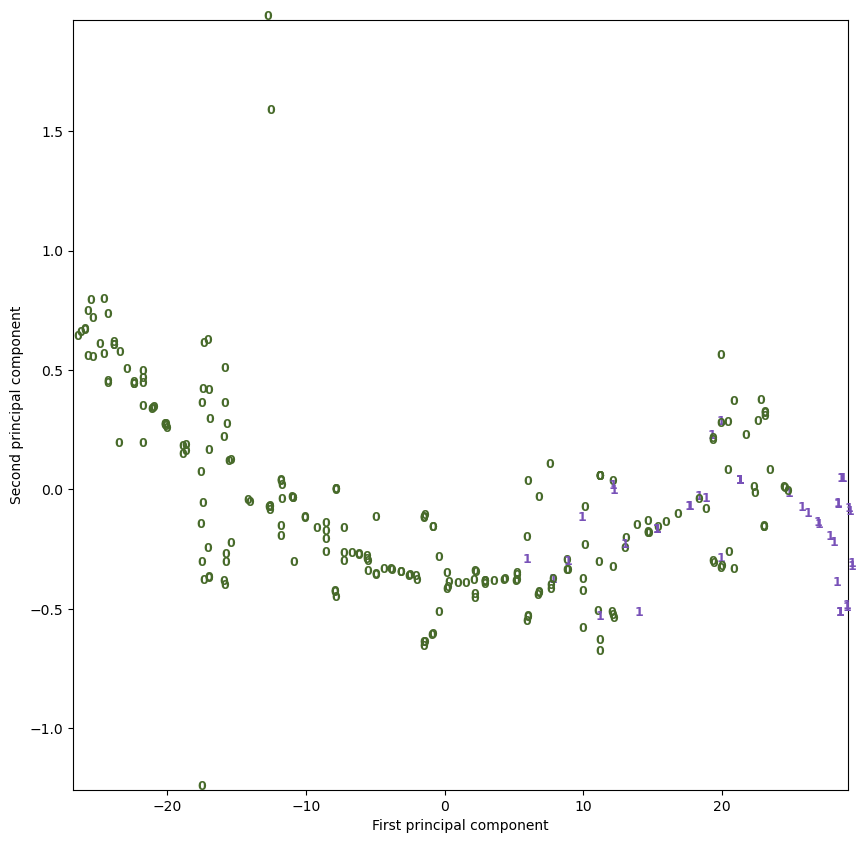

In [55]:
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
plt.figure(figsize=(10, 10))
plt.xlim(label_1_tsne[:, 0].min(), label_1_tsne[:, 0].max())
plt.ylim(label_1_tsne[:, 1].min(), label_1_tsne[:, 1].max())
for i in range(len(label_1)):
    # actually plot the digits as text instead of using scatter
    plt.text(label_1_tsne[i, 0], label_1_tsne[i, 1], str(list(label_1['cluster'])[i]),
             color = colors[list(label_1['cluster'])[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
#상대적으로 잘 뭉쳐져있다! -> 시각화하는데 잘 사용됨.

## Clustering Algorithm(2)- Agglomerative Clustering

In [13]:
from sklearn.cluster import AgglomerativeClustering

agg_sil_scores=[]
#ward,complete,average,single -> 선택
linkages = ['ward','complete','average','single']
for linkage in linkages:
    linkage_sil_scores =[]
    for n_cluster in range(2,14):
        agg = AgglomerativeClustering(n_clusters=n_cluster,linkage=linkage)
        agg.fit(label_1_scaled)
        cluster_labels=agg.labels_
        linkage_sil_scores.append(silhouette_score(label_1_scaled,cluster_labels))
    agg_sil_scores.append(linkage_sil_scores)


In [14]:
agg_sil_scores=np.stack(agg_sil_scores)
for i in range(4):
    print('{}의 최대 silhouette score :{}'.format(linkages[i],agg_sil_scores[i].max()))
#ward의 silhouette score가 가장 높음 -> ward를 선택

ward의 최대 silhouette score :0.7144534943579282
complete의 최대 silhouette score :0.7144534943579282
average의 최대 silhouette score :0.7144534943579282
single의 최대 silhouette score :0.7144534943579282


Text(0.5, 1.0, 'Silhouette Score')

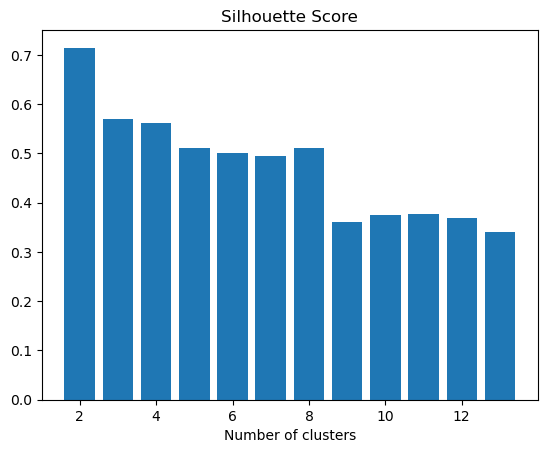

In [15]:
plt.bar(range(2,14),agg_sil_scores[0],)
plt.xlabel("Number of clusters")
plt.title("Silhouette Score")

In [41]:
n_cluster = 2
linkage='ward'
best_agg = AgglomerativeClustering(n_clusters=n_cluster,linkage=linkage)
best_agg.fit(label_1_scaled)
best_agg_sil_score=silhouette_score(label_1_scaled,best_agg.labels_)
print('Best agglomerative clustering silhouette score:',best_agg_sil_score)

Best agglomerative clustering silhouette score: 0.7144534943579282


In [42]:
cluster_labels=best_agg.fit_predict(label_1_scaled)

In [43]:
label_1['cluster']=cluster_labels
label_1

,r_1,n_5,r_5,r_9,r_12,n_171,r_171,n_172,r_172,n_173,...,r_194,r_195,n_196,r_196,r_197,r_198,r_199,n_175,r_175,cluster
476,4.294967e+09,98.0,2.0,40175.0,28.0,100.0,4.0,100.0,0.0,1.0,...,20.0,1.067805e+09,99.0,2.0,0.0,0.0,0.0,100.0,1.018337e+12,0
486,4.294967e+09,98.0,0.0,40012.0,59.0,100.0,0.0,100.0,0.0,1.0,...,16.0,2.260676e+09,100.0,0.0,0.0,0.0,0.0,100.0,1.005077e+12,0
1336,4.294967e+09,98.0,0.0,36922.0,30.0,100.0,0.0,100.0,0.0,1.0,...,18.0,1.591232e+09,100.0,0.0,0.0,0.0,0.0,100.0,9.407059e+11,0
1342,4.294967e+09,98.0,0.0,36522.0,28.0,100.0,0.0,100.0,0.0,83.0,...,14.0,2.791970e+08,100.0,0.0,0.0,0.0,0.0,100.0,9.280304e+11,0
1403,4.294967e+09,94.0,141.0,37481.0,30.0,99.0,70.0,100.0,0.0,1.0,...,8.0,2.748596e+09,97.0,141.0,0.0,0.0,0.0,100.0,9.497040e+11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64872,4.294967e+09,96.0,0.0,44625.0,36.0,100.0,0.0,100.0,0.0,97.0,...,15.0,1.270160e+06,100.0,0.0,0.0,0.0,0.0,1.0,1.134050e+12,0
65353,4.294967e+09,98.0,0.0,44244.0,27.0,100.0,0.0,100.0,0.0,1.0,...,19.0,2.581993e+09,100.0,0.0,0.0,0.0,0.0,100.0,1.125316e+12,0
65429,4.294967e+09,98.0,0.0,40585.0,28.0,100.0,0.0,100.0,0.0,1.0,...,15.0,1.579518e+09,100.0,0.0,0.0,0.0,0.0,100.0,1.035432e+12,0
65911,4.294967e+09,98.0,0.0,42078.0,44.0,100.0,0.0,100.0,0.0,1.0,...,17.0,3.873290e+09,100.0,0.0,0.0,0.0,0.0,100.0,1.057160e+12,0


In [44]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(label_1)
label_1_pca = pca.transform(label_1)

In [45]:
# dim reduction with tsne
tsne = TSNE(random_state=42)
# use fit_transform instead of fit, as TSNE has no transform method. not be used as preprocessing step of supervised learning
label_1_tsne = tsne.fit_transform(label_1)

Text(0, 0.5, 'Second principal component')

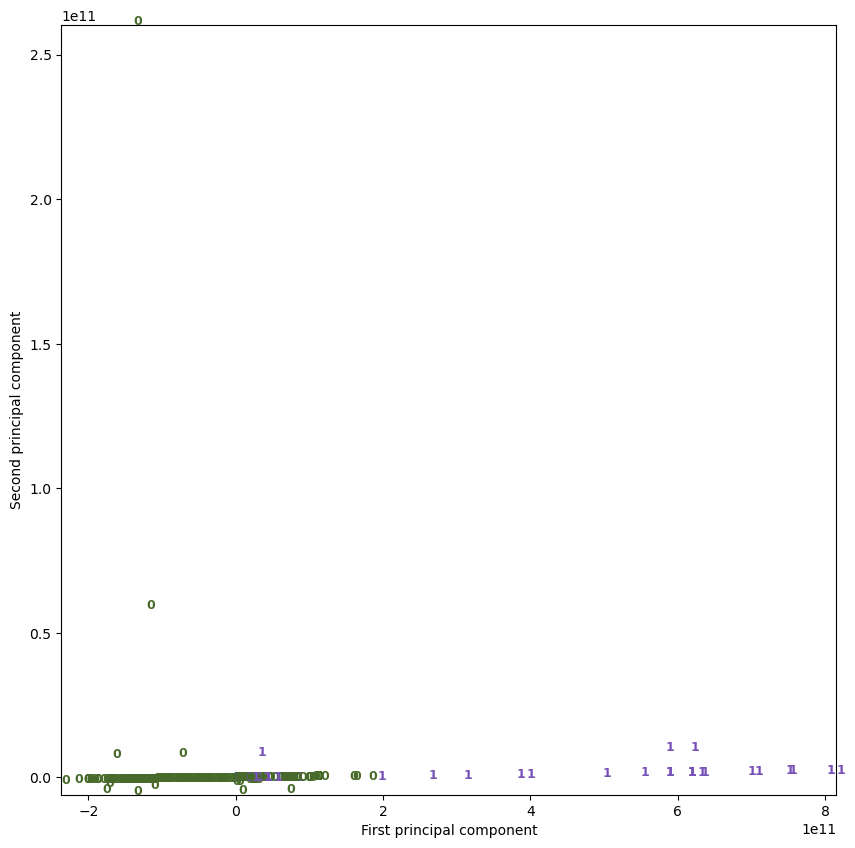

In [46]:
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
plt.figure(figsize=(10, 10))
plt.xlim(label_1_pca[:, 0].min(), label_1_pca[:, 0].max())
plt.ylim(label_1_pca[:, 1].min(), label_1_pca[:, 1].max())
for i in range(len(label_1)):
    # actually plot the digits as text instead of using scatter
    plt.text(label_1_pca[i, 0], label_1_pca[i, 1], str(list(label_1['cluster'])[i]),
             color = colors[list(label_1['cluster'])[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
#중복되는 경우 많음. 난잡하게 섞여있다.

Text(0, 0.5, 'Second principal component')

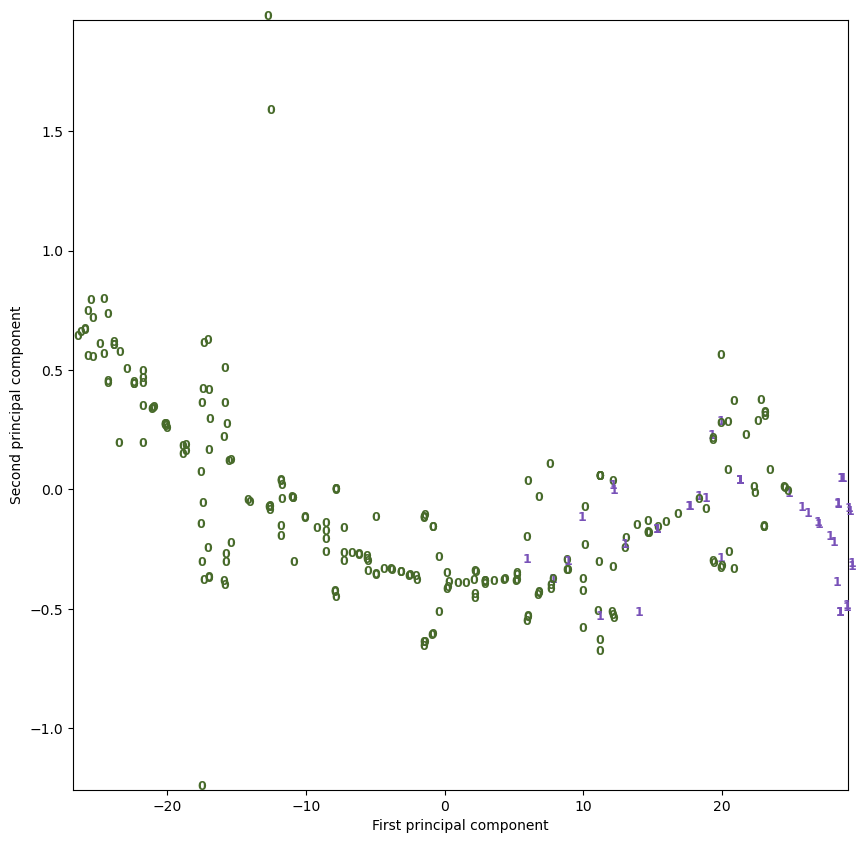

In [47]:
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
plt.figure(figsize=(10, 10))
plt.xlim(label_1_tsne[:, 0].min(), label_1_tsne[:, 0].max())
plt.ylim(label_1_tsne[:, 1].min(), label_1_tsne[:, 1].max())
for i in range(len(label_1)):
    # actually plot the digits as text instead of using scatter
    plt.text(label_1_tsne[i, 0], label_1_tsne[i, 1], str(list(label_1['cluster'])[i]),
             color = colors[list(label_1['cluster'])[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
#상대적으로 잘 뭉쳐져있다! -> 시각화하는데 잘 사용됨.

## Clustering Algorithm(3) - DBSCAN

In [23]:
from sklearn.cluster import DBSCAN

eps_list=[1,1.5,1.8,2,2.5]
min_samples=[2,3,4,5,6,7]

dbscan_sil_scores =[]

for eps in eps_list:
    dbscan_sil=[]
    for ms in min_samples:
        dbscan = DBSCAN(eps=eps,min_samples=ms)
        dbscan.fit(label_1_scaled)
        cluster_labels = dbscan.labels_
        dbscan_sil.append(silhouette_score(label_1_scaled,cluster_labels))
    dbscan_sil_scores.append(dbscan_sil)

dbscan_sil_scores=np.stack(dbscan_sil_scores)
dbscan_sil_scores

array([[0.55245542, 0.55245542, 0.56064012, 0.56064012, 0.56064012,
        0.56064012],
       [0.68014128, 0.68014128, 0.68014128, 0.68014128, 0.68014128,
        0.68014128],
       [0.68014128, 0.68014128, 0.68014128, 0.68014128, 0.68014128,
        0.68014128],
       [0.71445349, 0.71445349, 0.71445349, 0.71445349, 0.71445349,
        0.71445349],
       [0.71445349, 0.71445349, 0.71445349, 0.71445349, 0.71445349,
        0.71445349]])

In [24]:
max_scores=[]
for i in range(len(eps_list)):
    max_scores.append(dbscan_sil_scores[i].max())
max_index=max_scores.index(max(max_scores))

print('silhouette score의 최대:',max_scores[max_index])
print('silhouette score가 최대일때, eps:',eps_list[max_index])

silhouette score의 최대: 0.7144534943579282
silhouette score가 최대일때, eps: 2


In [37]:
best_dbscan=DBSCAN(eps=2,min_samples=3)
best_dbscan.fit(label_1_scaled)
best_dbscan_sil_score=silhouette_score(label_1_scaled,best_dbscan.labels_)
print('Best DBSCAN clustering silhouette score:',best_dbscan_sil_score)

Best DBSCAN clustering silhouette score: 0.7144534943579282


In [38]:
label_1['cluster']=best_dbscan.fit_predict(label_1_scaled)
label_1

,r_1,n_5,r_5,r_9,r_12,n_171,r_171,n_172,r_172,n_173,...,r_194,r_195,n_196,r_196,r_197,r_198,r_199,n_175,r_175,cluster
476,4.294967e+09,98.0,2.0,40175.0,28.0,100.0,4.0,100.0,0.0,1.0,...,20.0,1.067805e+09,99.0,2.0,0.0,0.0,0.0,100.0,1.018337e+12,0
486,4.294967e+09,98.0,0.0,40012.0,59.0,100.0,0.0,100.0,0.0,1.0,...,16.0,2.260676e+09,100.0,0.0,0.0,0.0,0.0,100.0,1.005077e+12,0
1336,4.294967e+09,98.0,0.0,36922.0,30.0,100.0,0.0,100.0,0.0,1.0,...,18.0,1.591232e+09,100.0,0.0,0.0,0.0,0.0,100.0,9.407059e+11,0
1342,4.294967e+09,98.0,0.0,36522.0,28.0,100.0,0.0,100.0,0.0,83.0,...,14.0,2.791970e+08,100.0,0.0,0.0,0.0,0.0,100.0,9.280304e+11,0
1403,4.294967e+09,94.0,141.0,37481.0,30.0,99.0,70.0,100.0,0.0,1.0,...,8.0,2.748596e+09,97.0,141.0,0.0,0.0,0.0,100.0,9.497040e+11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64872,4.294967e+09,96.0,0.0,44625.0,36.0,100.0,0.0,100.0,0.0,97.0,...,15.0,1.270160e+06,100.0,0.0,0.0,0.0,0.0,1.0,1.134050e+12,0
65353,4.294967e+09,98.0,0.0,44244.0,27.0,100.0,0.0,100.0,0.0,1.0,...,19.0,2.581993e+09,100.0,0.0,0.0,0.0,0.0,100.0,1.125316e+12,0
65429,4.294967e+09,98.0,0.0,40585.0,28.0,100.0,0.0,100.0,0.0,1.0,...,15.0,1.579518e+09,100.0,0.0,0.0,0.0,0.0,100.0,1.035432e+12,0
65911,4.294967e+09,98.0,0.0,42078.0,44.0,100.0,0.0,100.0,0.0,1.0,...,17.0,3.873290e+09,100.0,0.0,0.0,0.0,0.0,100.0,1.057160e+12,0


In [39]:
label_1['cluster'].value_counts()

0    229
1     46
Name: cluster, dtype: int64

<BarContainer object of 3 artists>

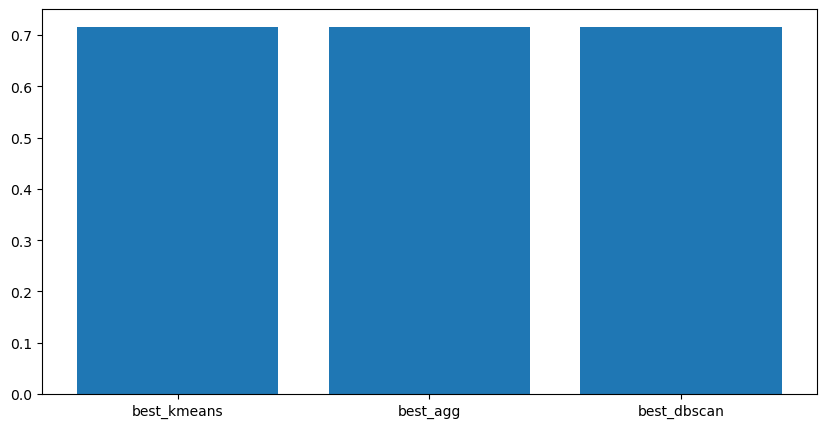

In [57]:
clusterings_sil_scores = [best_kmeans_sil_score,best_agg_sil_score,best_dbscan_sil_score]
cluster_names = ['best_kmeans','best_agg','best_dbscan']
plt.figure(figsize=(10,5))
plt.bar(cluster_names,clusterings_sil_scores,)

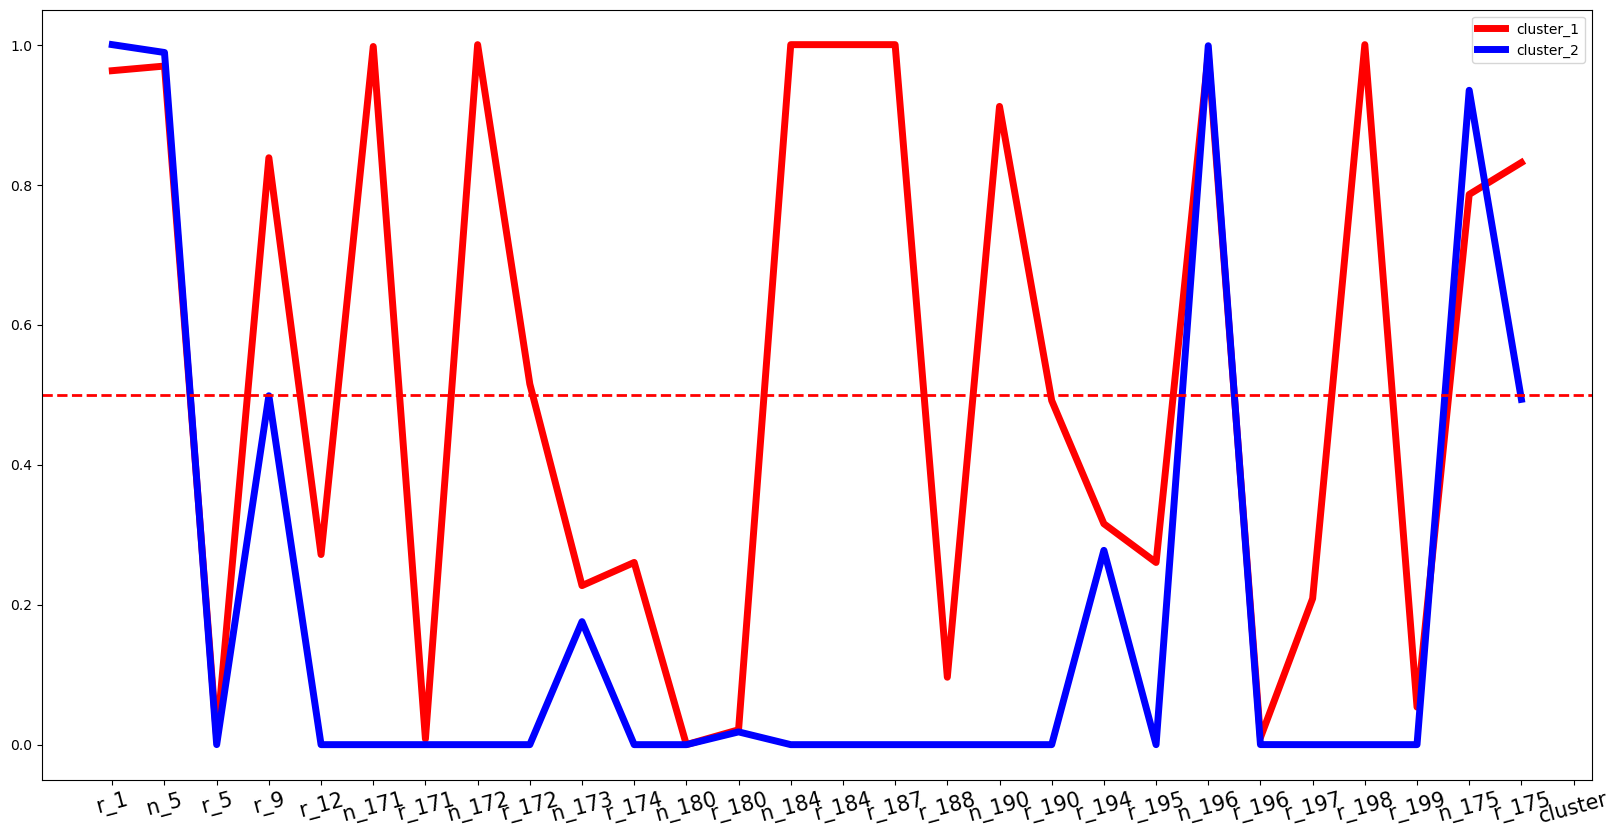

In [56]:
plt.figure(figsize=(20,10))

plt.plot(range(0,28),best_kmeans.cluster_centers_[0],linewidth=5, color='red', label='cluster_1')
plt.plot(range(0,28),best_kmeans.cluster_centers_[1], linewidth=5, color='blue', label='cluster_2')
plt.legend()
plt.axhline(0.5, color='red', linestyle='--', linewidth=2)
plt.xticks(np.arange(0,29),label_1.columns,rotation=15 ,fontsize=15)
plt.show()

In [31]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(label_1)
label_1_pca = pca.transform(label_1)

In [32]:
# dim reduction with tsne
tsne = TSNE(random_state=42)
# use fit_transform instead of fit, as TSNE has no transform method. not be used as preprocessing step of supervised learning
label_1_tsne = tsne.fit_transform(label_1)

Text(0, 0.5, 'Second principal component')

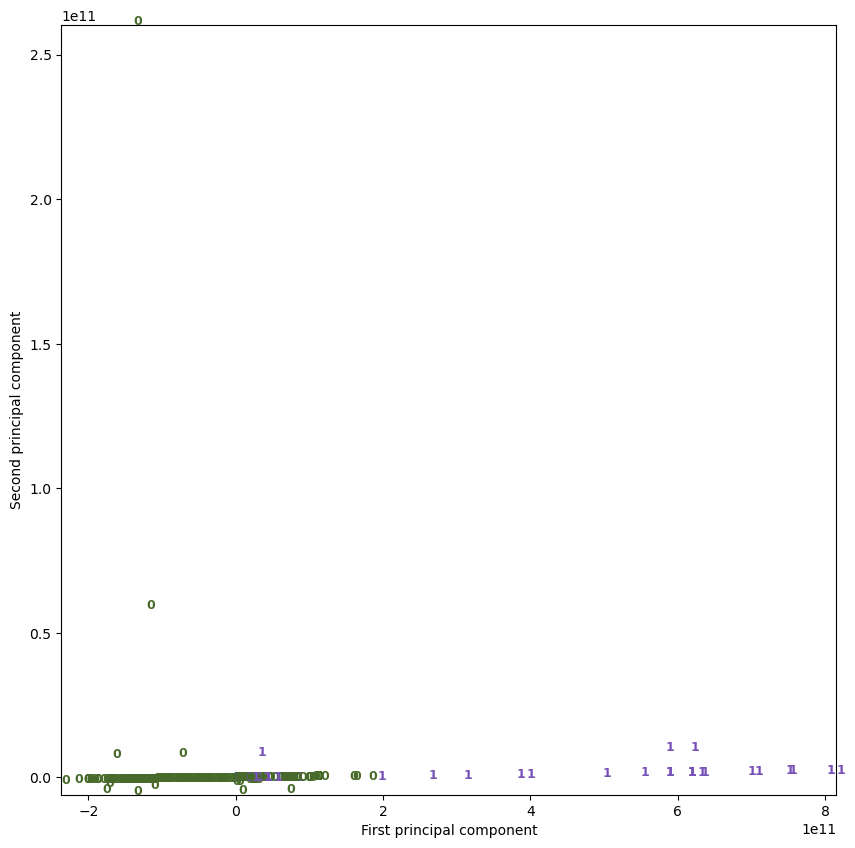

In [58]:
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
plt.figure(figsize=(10, 10))
plt.xlim(label_1_pca[:, 0].min(), label_1_pca[:, 0].max())
plt.ylim(label_1_pca[:, 1].min(), label_1_pca[:, 1].max())
for i in range(len(label_1)):
    # actually plot the digits as text instead of using scatter
    plt.text(label_1_pca[i, 0], label_1_pca[i, 1], str(list(label_1['cluster'])[i]),
             color = colors[list(label_1['cluster'])[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
#중복되는 경우 많음. 난잡하게 섞여있다.

Text(0, 0.5, 'Second principal component')

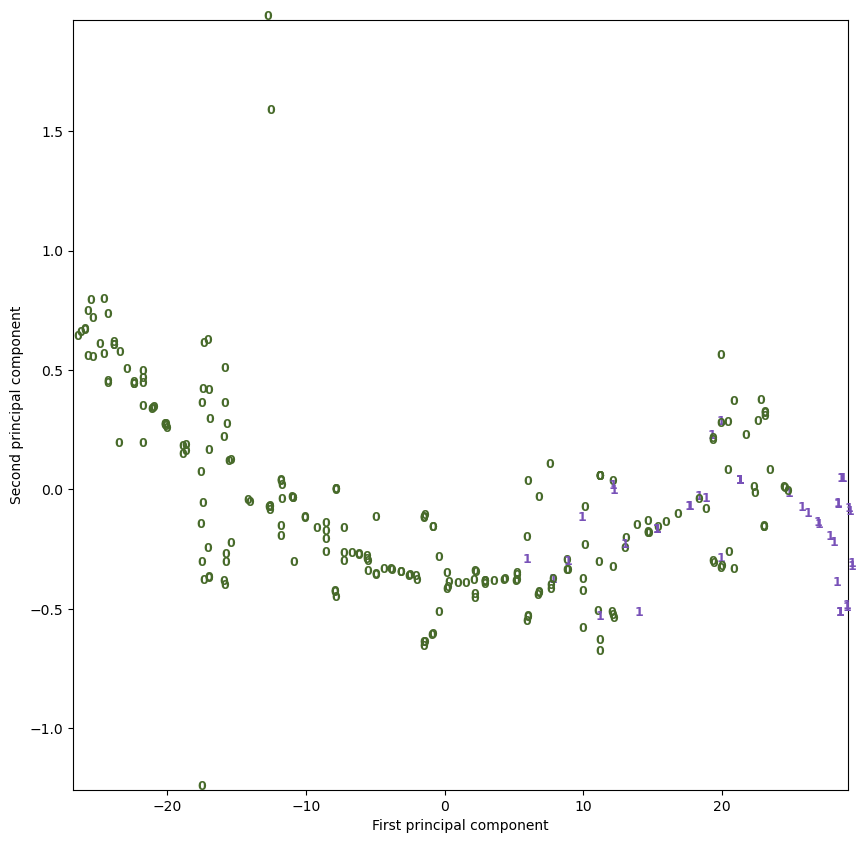

In [59]:
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
plt.figure(figsize=(10, 10))
plt.xlim(label_1_tsne[:, 0].min(), label_1_tsne[:, 0].max())
plt.ylim(label_1_tsne[:, 1].min(), label_1_tsne[:, 1].max())
for i in range(len(label_1)):
    # actually plot the digits as text instead of using scatter
    plt.text(label_1_tsne[i, 0], label_1_tsne[i, 1], str(list(label_1['cluster'])[i]),
             color = colors[list(label_1['cluster'])[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
#상대적으로 잘 뭉쳐져있다! -> 시각화하는데 잘 사용됨.